# 1. Choose a COVID-19 API of your choice that contains both valuable data and noise.

API="https://api.coronavirus.data.gov.uk/v1/data"

# 2. Use Python to gather the data from the API and store it in a Pandas DataFrame.

In [34]:
from typing import Iterable, Dict, Union, List
from json import dumps
from requests import get
from http import HTTPStatus


StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]


def get_paginated_dataset(filters: FiltersType, structure: StructureType,
                          as_csv: bool = False) -> APIResponseType:
    """
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.

    as_csv: bool
        Return the data as CSV. [default: ``False``]

    Returns
    -------
    Union[List[StructureType], str]
        Comprehensive list of dictionaries containing all the data for
        the given ``filters`` and ``structure``.
    """
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": str.join(";", filters),
        "structure": dumps(structure, separators=(",", ":")),
        "format": "json" if not as_csv else "csv"
    }

    data = list()

    page_number = 1

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = get(endpoint, params=api_params, timeout=10)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        if as_csv:
            csv_content = response.content.decode()

            # Removing CSV header (column names) where page 
            # number is greater than 1.
            if page_number > 1:
                data_lines = csv_content.split("\n")[1:]
                csv_content = str.join("\n", data_lines)

            data.append(csv_content.strip())
            page_number += 1
            continue

        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    if not as_csv:
        return data

    # Concatenating CSV pages
    return str.join("\n", data)


if __name__ == "__main__":
    query_filters = [
        f"areaType=region"
    ]

    query_structure = {
        "date": "date",
        "name": "areaName",
        "code": "areaCode",
        "dailyCases": "newCasesByPublishDate",
        "cumulativeCases": "cumCasesByPublishDate",
        "dailyDeaths": "newDeaths28DaysByPublishDate",
        "cumulativeDeaths": "cumDeaths28DaysByPublishDate"
    }
    
    json_data = get_paginated_dataset(query_filters, query_structure)
    print("JSON:")
    print(f"Length:", len(json_data))
    print("Data (first 3 items):", json_data[:3])

    print("---" * 10)
    
    csv_data = get_paginated_dataset(query_filters, query_structure, as_csv=True)
    csv_lines = csv_data.split("\n")
    print("CSV:")
    print(f"Length:", len(csv_lines))
    print("Data (first 3 lines):", csv_lines[:3])

JSON:
Length: 10838
Data (first 3 items): [{'date': '2023-08-03', 'name': 'North West', 'code': 'E12000002', 'dailyCases': 110, 'cumulativeCases': 2848009, 'dailyDeaths': None, 'cumulativeDeaths': None}, {'date': '2023-08-02', 'name': 'North West', 'code': 'E12000002', 'dailyCases': 136, 'cumulativeCases': 2847899, 'dailyDeaths': None, 'cumulativeDeaths': None}, {'date': '2023-08-01', 'name': 'North West', 'code': 'E12000002', 'dailyCases': 108, 'cumulativeCases': 2847763, 'dailyDeaths': None, 'cumulativeDeaths': None}]
------------------------------
CSV:
Length: 10839
Data (first 3 lines): ['date,name,code,dailyCases,cumulativeCases,dailyDeaths,cumulativeDeaths', '2023-08-03,North West,E12000002,110,2848009,,', '2023-08-02,North West,E12000002,136,2847899,,']


In [36]:
json_data

[{'date': '2023-08-03',
  'name': 'North West',
  'code': 'E12000002',
  'dailyCases': 110,
  'cumulativeCases': 2848009,
  'dailyDeaths': None,
  'cumulativeDeaths': None},
 {'date': '2023-08-02',
  'name': 'North West',
  'code': 'E12000002',
  'dailyCases': 136,
  'cumulativeCases': 2847899,
  'dailyDeaths': None,
  'cumulativeDeaths': None},
 {'date': '2023-08-01',
  'name': 'North West',
  'code': 'E12000002',
  'dailyCases': 108,
  'cumulativeCases': 2847763,
  'dailyDeaths': None,
  'cumulativeDeaths': None},
 {'date': '2023-07-31',
  'name': 'North West',
  'code': 'E12000002',
  'dailyCases': 76,
  'cumulativeCases': 2847655,
  'dailyDeaths': None,
  'cumulativeDeaths': None},
 {'date': '2023-07-30',
  'name': 'North West',
  'code': 'E12000002',
  'dailyCases': 78,
  'cumulativeCases': 2847579,
  'dailyDeaths': None,
  'cumulativeDeaths': None},
 {'date': '2023-07-29',
  'name': 'North West',
  'code': 'E12000002',
  'dailyCases': 102,
  'cumulativeCases': 2847501,
  'dailyDe

In [38]:
df = pd.DataFrame(json_data, columns=['date','name','code','dailyCases','cumulativeCases','dailyDeaths'])

In [39]:
df

,date,name,code,dailyCases,cumulativeCases,dailyDeaths
0,2023-08-03,North West,E12000002,110.0,2848009.0,NaN
1,2023-08-02,North West,E12000002,136.0,2847899.0,NaN
2,2023-08-01,North West,E12000002,108.0,2847763.0,NaN
3,2023-07-31,North West,E12000002,76.0,2847655.0,NaN
4,2023-07-30,North West,E12000002,78.0,2847579.0,NaN
...,...,...,...,...,...,...
10833,2020-04-21,West Midlands,E12000005,330.0,10117.0,NaN
10834,2020-04-20,West Midlands,E12000005,360.0,9787.0,NaN
10835,2020-04-19,West Midlands,E12000005,382.0,9427.0,NaN
10836,2020-04-18,West Midlands,E12000005,327.0,9045.0,NaN


# NB: Les caracteristiques de ce dataset ne nous permet pas de developper un model de ML. Par conséquent pour continuer le Checkpoint, nous allons utilser un autre dataset que nous avons telechargé sur "https://www.kaggle.com/datasets/meirnizri/covid19-dataset/download?datasetVersionNumber=1"

## Objectif: prédire les patients qui présentent un risque élevé de décès par covid 19

## importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from itertools import product
import seaborn as sns
import plotly.express as px
import missingno as msno # for missing data
import sweetviz as sv #Sweetviz Library for EDA


from sklearn.model_selection import train_test_split
# Preprocessing Data
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  RobustScaler
from sklearn.model_selection import GridSearchCV

# supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,roc_auc_score, roc_curve,classification_report

from imblearn.under_sampling import RandomUnderSampler

## Lecture des données

In [2]:
# load and read dataset
from ydata_profiling.utils.cache import cache_file
file_name = "Covid Data.csv"
data = pd.read_csv(file_name,sep=",")

## Analyse de la forme des données

In [3]:
# make a copy
df=data

In [4]:
# print header of dataframe
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
USMER,2,2,2,2,2,2,2,2,2,2
MEDICAL_UNIT,1,1,1,1,1,1,1,1,1,1
SEX,1,2,2,1,2,1,1,1,1,1
PATIENT_TYPE,1,1,2,1,1,2,1,1,2,2
DATE_DIED,03/05/2020,03/06/2020,09/06/2020,12/06/2020,21/06/2020,9999-99-99,9999-99-99,9999-99-99,9999-99-99,9999-99-99
INTUBED,97,97,1,97,97,2,97,97,2,2
PNEUMONIA,1,1,2,2,2,1,2,1,2,2
AGE,65,72,55,53,68,40,64,64,37,25
PREGNANT,2,97,97,2,97,2,2,2,2,2
DIABETES,2,2,1,2,1,2,2,1,1,2


In [5]:
# columns names
print(df.columns.values)

['USMER' 'MEDICAL_UNIT' 'SEX' 'PATIENT_TYPE' 'DATE_DIED' 'INTUBED'
 'PNEUMONIA' 'AGE' 'PREGNANT' 'DIABETES' 'COPD' 'ASTHMA' 'INMSUPR'
 'HIPERTENSION' 'OTHER_DISEASE' 'CARDIOVASCULAR' 'OBESITY' 'RENAL_CHRONIC'
 'TOBACCO' 'CLASIFFICATION_FINAL' 'ICU']



### Comprehension des données:

Cet ensemble de données contient un très grand nombre d'informations anonymes relatives aux patients, y compris des conditions préalables. L'ensemble de données brutes comprend 21 caractéristiques uniques et 1 048 576 patients uniques. Dans les caractéristiques booléennes, 1 signifie "oui" et 2 signifie "non". Les valeurs 97 et 99 sont des données manquantes.

'SEX': femme ou homme

'AGE': du patient.

'CLASIFFICATION_FINAL': résultats du test covid. Les valeurs 1 à 3 signifient que le patient a été diagnostiqué avec une covid à différents degrés. 4 ou plus signifie que le patient n'est pas porteur de la covid ou que le test n'est pas concluant.

'PATIENT_TYPE': hospitalisé ou non hospitalisé.

'PNEUMONIA': si le patient présente déjà une inflammation des sacs aériens ou non.

'PREGNANT': si la patiente est enceinte ou non.

'DIABETES': si le patient est diabétique ou non.

'COPD': Indique si le patient souffre ou non d'une maladie pulmonaire obstructive chronique.

'ASTHMA': si le patient est asthmatique ou non.

'INMSUPR': si le patient est immunodéprimé ou non.

'HIPERTENSION': si le patient souffre ou non d'hypertension.

'CARDIOVASCULAR': si le patient souffre d'une maladie du cœur ou des vaisseaux sanguins.

'RENAL_CHRONIC': le fait que le patient souffre ou non d'une maladie rénale chronique.

'OTHER_DISEASE': si le patient est atteint d'une autre maladie ou non.

'OBESITY': si le patient est obèse ou non.

'TOBACCO': si le patient consomme du tabac.

'USMER': Indique si le patient a été traité par des unités médicales de premier, deuxième ou troisième niveau.

'MEDICAL_UNIT': le type d'institution du système national de santé qui a fourni les soins.

'INTUBED': si le patient était relié au ventilateur.

'ICU': Indique si le patient a été admis dans une unité de soins intensifs.

'DATE_DIED': la date de décés du patient s'il est décédé.

In [6]:
# nomber of lines and columns
df.shape

(1048575, 21)

In [7]:
#types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [8]:
df.dtypes.value_counts()

int64     20
object     1
dtype: int64

In [9]:
# Checking missing values
df.isnull().sum().sort_values(ascending=False)

USMER                   0
ASTHMA                  0
CLASIFFICATION_FINAL    0
TOBACCO                 0
RENAL_CHRONIC           0
OBESITY                 0
CARDIOVASCULAR          0
OTHER_DISEASE           0
HIPERTENSION            0
INMSUPR                 0
COPD                    0
MEDICAL_UNIT            0
DIABETES                0
PREGNANT                0
AGE                     0
PNEUMONIA               0
INTUBED                 0
DATE_DIED               0
PATIENT_TYPE            0
SEX                     0
ICU                     0
dtype: int64

Nous n'avons pas de valeurs NaN mais nous aurons des valeurs manquantes car dans la description des données on nous a notifié  que 
les valeurs 97 et 99 sont des données manquantes.

In [10]:
print('Percentage of missing values')
for col in df.columns :
    print('{:<20} => {:>10.2f}%'.format(col, len(df[(df[col]==98) | (df[col]==99) | (df[col]==97)])/len(df)*100))

Percentage of missing values
USMER                =>       0.00%
MEDICAL_UNIT         =>       0.00%
SEX                  =>       0.00%
PATIENT_TYPE         =>       0.00%
DATE_DIED            =>       0.00%
INTUBED              =>      81.62%
PNEUMONIA            =>       1.53%
AGE                  =>       0.03%
PREGNANT             =>      50.28%
DIABETES             =>       0.32%
COPD                 =>       0.29%
ASTHMA               =>       0.28%
INMSUPR              =>       0.32%
HIPERTENSION         =>       0.30%
OTHER_DISEASE        =>       0.48%
CARDIOVASCULAR       =>       0.29%
OBESITY              =>       0.29%
RENAL_CHRONIC        =>       0.29%
TOBACCO              =>       0.31%
CLASIFFICATION_FINAL =>       0.00%
ICU                  =>      81.64%


In [80]:
#classification or reclassification of variables according to type or function:
# view on https://www.kaggle.com/code/ozlemilgun/the-prediction-of-titanic-passengers-survival

def grab_col_names(dataframe, cat_th=5, car_th=20):
    """
    This function to perform the selection of numeric and categorical variables in the data set in a parametric way.
    Note: Variables with numeric data type but with categorical properties are included in categorical variables.

    Parameters
    ----------
    dataframe: dataframe
        The data set in which Variable types need to be parsed
    cat_th: int, optional
        The threshold value for number of distinct observations in numerical variables with categorical properties.
        cat_th is used to specify that if number of distinct observations in numerical variable is less than
        cat_th, this variables can be categorized as a categorical variable.

    car_th: int, optional
        The threshold value for categorical variables with  a wide range of cardinality.
        If the number of distinct observations in a categorical variables is greater than car_th, this
        variable can be categorized as a categorical variable.

    Returns
    -------
        cat_cols: list
            List of categorical variables.
        num_cols: list
            List of numerical variables.
        cat_but_car: list
            List of categorical variables with  a wide range of cardinality.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    Notes
    ------
        Sum of elements in lists the cat_cols,num_cols  and  cat_but_car give the total number of variables in dataframe.
    """

    # cat cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and
                   dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and
                   dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and "ID" not in col.upper()]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols,num_cols,cat_but_car


In [13]:
grab_col_names(df)

(['USMER',
  'SEX',
  'PATIENT_TYPE',
  'INTUBED',
  'PNEUMONIA',
  'PREGNANT',
  'DIABETES',
  'COPD',
  'ASTHMA',
  'INMSUPR',
  'HIPERTENSION',
  'OTHER_DISEASE',
  'CARDIOVASCULAR',
  'OBESITY',
  'RENAL_CHRONIC',
  'TOBACCO',
  'ICU'],
 ['MEDICAL_UNIT', 'AGE', 'CLASIFFICATION_FINAL'],
 ['DATE_DIED'])

In [14]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [15]:
for col in cat_cols:
    print(f'{col :-<50} {df[col].unique()}')

USMER--------------------------------------------- [2 1]
SEX----------------------------------------------- [1 2]
PATIENT_TYPE-------------------------------------- [1 2]
INTUBED------------------------------------------- [97  1  2 99]
PNEUMONIA----------------------------------------- [ 1  2 99]
PREGNANT------------------------------------------ [ 2 97 98  1]
DIABETES------------------------------------------ [ 2  1 98]
COPD---------------------------------------------- [ 2  1 98]
ASTHMA-------------------------------------------- [ 2  1 98]
INMSUPR------------------------------------------- [ 2  1 98]
HIPERTENSION-------------------------------------- [ 1  2 98]
OTHER_DISEASE------------------------------------- [ 2  1 98]
CARDIOVASCULAR------------------------------------ [ 2  1 98]
OBESITY------------------------------------------- [ 2  1 98]
RENAL_CHRONIC------------------------------------- [ 2  1 98]
TOBACCO------------------------------------------- [ 2  1 98]
ICU--------------

In [16]:
df.DATE_DIED.value_counts()

9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: DATE_DIED, Length: 401, dtype: int64

In [17]:
df['TOBACCO'].value_counts()

2     960979
1      84376
98      3220
Name: TOBACCO, dtype: int64

In [18]:
df['INTUBED'].value_counts()

97    848544
2     159050
1      33656
99      7325
Name: INTUBED, dtype: int64

In [19]:
df['PREGNANT'].value_counts()

97    523511
2     513179
1       8131
98      3754
Name: PREGNANT, dtype: int64

In [20]:
df['ICU'].value_counts()

97    848544
2     175685
1      16858
99      7488
Name: ICU, dtype: int64

Certaines caractéristiques ne devraient avoir que 2 valeurs uniques, mais nous constatons qu'elles en ont 3 ou 4. Par exemple, la caractéristique "PNEUMONIE" a 3 valeurs uniques (1,2,99). 

INTUBED, PREGNANT, ICU  ont de nombreuses valeurs manquantes, indiquées par 97,99 d'autres colonnes ont des valeurs manquantes moins importantes, indiquées par 98. Par conséquent, nous ne prendrons que les lignes qui comprennent 1 et 2 valeurs. 

Dans la colonne "DATE_DIED", nous avons 971633 valeurs "9999-99-99" qui représentent des patients en vie, donc je vais considérer cette caractéristique comme un "DEATH" qui inclut si le patient est décédé ou non.



In [21]:
df['CLASIFFICATION_FINAL'].value_counts()

7    499250
3    381527
6    128133
5     26091
1      8601
4      3122
2      1851
Name: CLASIFFICATION_FINAL, dtype: int64

1-3 : le patient a été diagnostiqué avec la covid à différents degrés
4-7 : le patient n'est pas porteur de la covid ou le test n'est pas concluant.

## Netoyage des données

Elimination des valeurs manquantes des caractéristiques, à l'exception de "INTUBED", "PREGNANT", "ICU".

In [4]:
df = df[(df.PNEUMONIA == 1) | (df.PNEUMONIA == 2)]
df = df[(df.DIABETES == 1) | (df.DIABETES == 2)]
df = df[(df.COPD == 1) | (df.COPD == 2)]
df = df[(df.ASTHMA == 1) | (df.ASTHMA == 2)]
df = df[(df.INMSUPR == 1) | (df.INMSUPR == 2)]
df = df[(df.HIPERTENSION == 1) | (df.HIPERTENSION == 2)]
df = df[(df.OTHER_DISEASE == 1) | (df.OTHER_DISEASE == 2)]
df = df[(df.CARDIOVASCULAR == 1) | (df.CARDIOVASCULAR == 2)]
df = df[(df.OBESITY == 1) | (df.OBESITY == 2)]
df = df[(df.RENAL_CHRONIC == 1) | (df.RENAL_CHRONIC == 2)]
df = df[(df.TOBACCO == 1) | (df.TOBACCO == 2)]

In [5]:
#creation de la colonne "DEATH" qui traduit la mort ou non du patient
df["DEATH"] = [2 if each=="9999-99-99" else 1 for each in df.DATE_DIED]

In [7]:
df['DEATH'].value_counts()

2    950438
1     74714
Name: DEATH, dtype: int64

Pas d'equilibre 

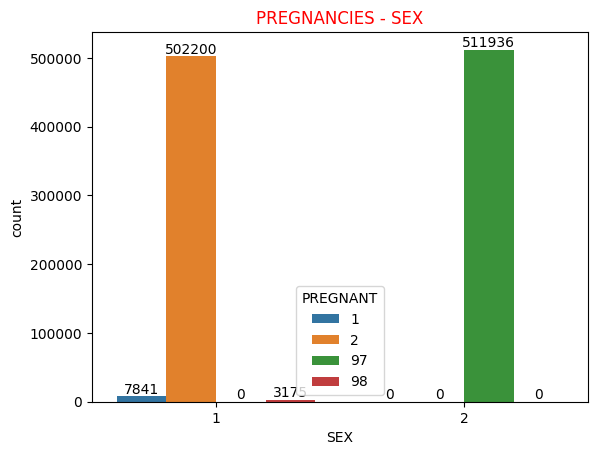

In [25]:
#Pregnant-Sex Bar Plot
plt.figure()
ax = sns.countplot(df,x=df.SEX, hue = df.PREGNANT)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("PREGNANCIES - SEX",color="red");

Nous constatons que toutes les valeurs "97" correspondent à des hommes et que les hommes ne peuvent pas être enceintes. Nous allons donc convertir 97 en 2.

In [6]:
# Converting process according to inference above
df.PREGNANT = df.PREGNANT.replace(97,2)

# Getting rid of the missing values
df = df[(df.PREGNANT == 1) | (df.PREGNANT == 2)]

Dans les caractéristiques  "INTUBED" et "ICU", il y a trop de valeurs manquantes, je vais donc les supprimer. De même, nous n'avons plus besoin de la colonne "DATE_DIED" car nous avons utilisé cette caractéristique comme caractéristique "DEATH".

In [7]:
df.drop(columns=["INTUBED","ICU","DATE_DIED"], inplace=True)

In [28]:
df.shape

(1021977, 19)

In [85]:
grab_col_names(df)

(['USMER',
  'SEX',
  'PATIENT_TYPE',
  'PNEUMONIA',
  'PREGNANT',
  'DIABETES',
  'COPD',
  'ASTHMA',
  'INMSUPR',
  'HIPERTENSION',
  'OTHER_DISEASE',
  'CARDIOVASCULAR',
  'OBESITY',
  'RENAL_CHRONIC',
  'TOBACCO',
  'DEATH'],
 ['MEDICAL_UNIT', 'AGE', 'CLASIFFICATION_FINAL'],
 [])

In [86]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [31]:
for col in cat_cols:
    print(f'{col :-<50} {df[col].unique()}')

USMER--------------------------------------------- [2 1]
SEX----------------------------------------------- [1 2]
PATIENT_TYPE-------------------------------------- [1 2]
PNEUMONIA----------------------------------------- [1 2]
PREGNANT------------------------------------------ [2 1]
DIABETES------------------------------------------ [2 1]
COPD---------------------------------------------- [2 1]
ASTHMA-------------------------------------------- [2 1]
INMSUPR------------------------------------------- [2 1]
HIPERTENSION-------------------------------------- [1 2]
OTHER_DISEASE------------------------------------- [2 1]
CARDIOVASCULAR------------------------------------ [2 1]
OBESITY------------------------------------------- [2 1]
RENAL_CHRONIC------------------------------------- [2 1]
TOBACCO------------------------------------------- [2 1]
DEATH--------------------------------------------- [1 2]


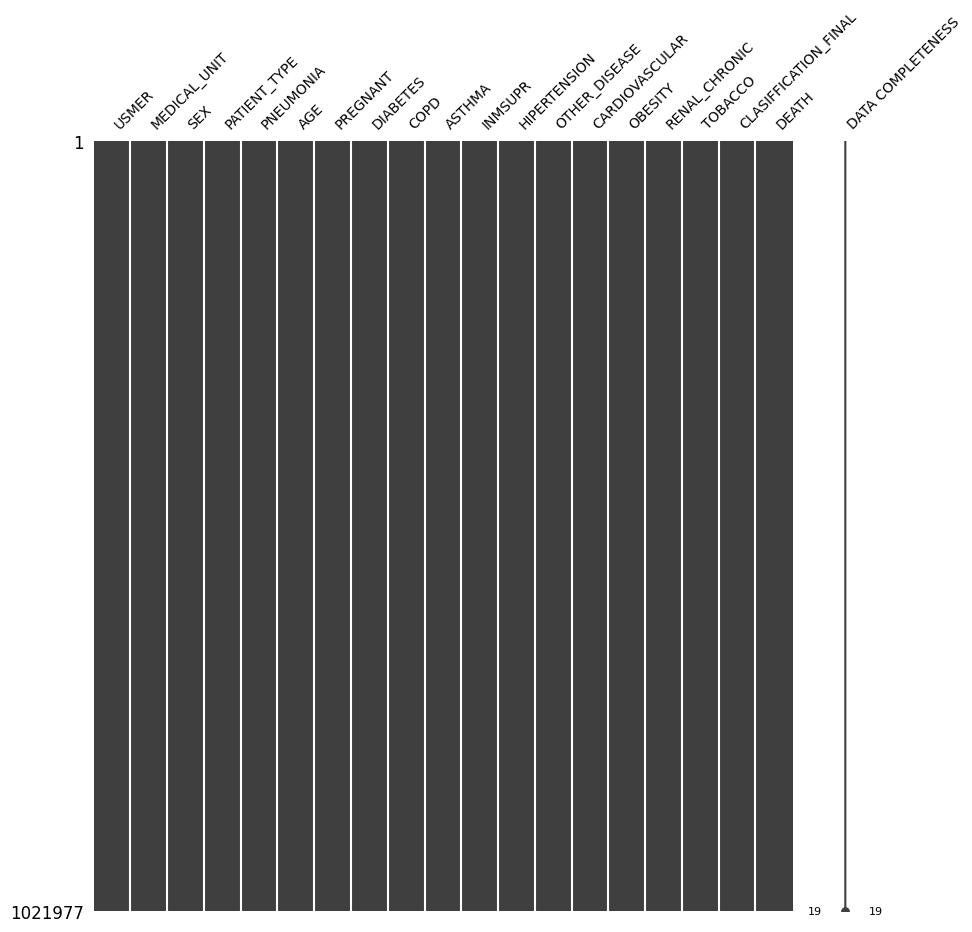

In [32]:
# La matrice de nullité msno.matrix est un affichage dense en données
#qui  permet de repérer rapidement et visuellement des modèles dans l'achèvement des données.
msno.matrix(df, figsize=(10,10), fontsize=10, labels=8)
plt.show()

## Analyse de fond des données

In [36]:
# creating report
report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)


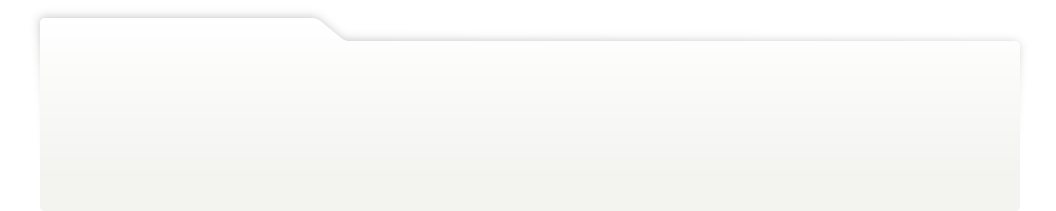
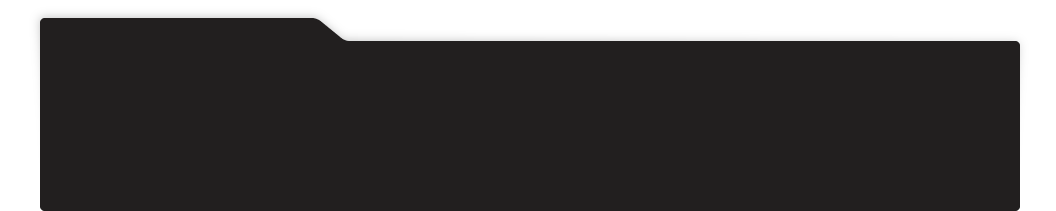
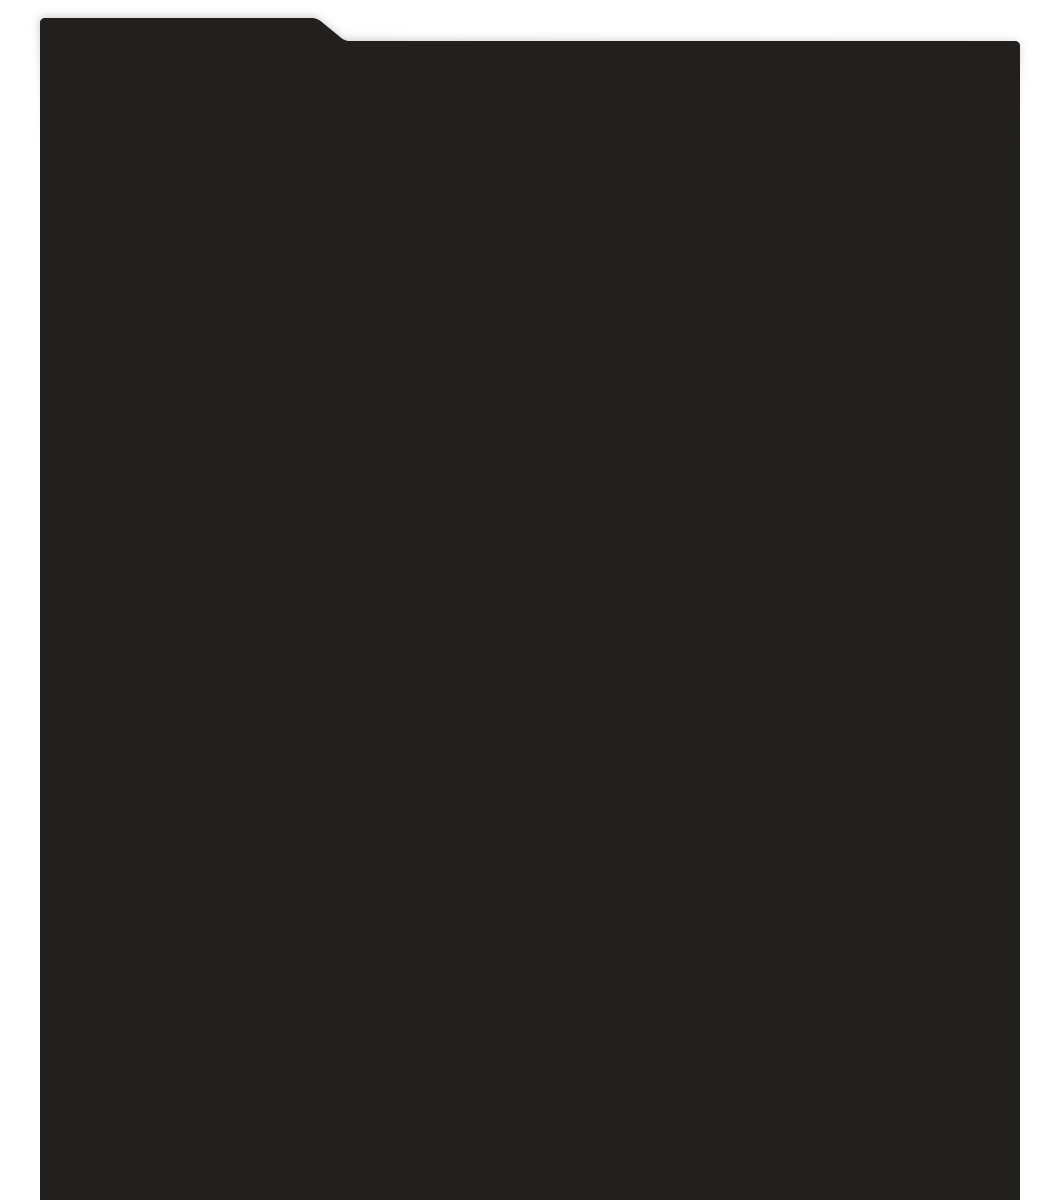
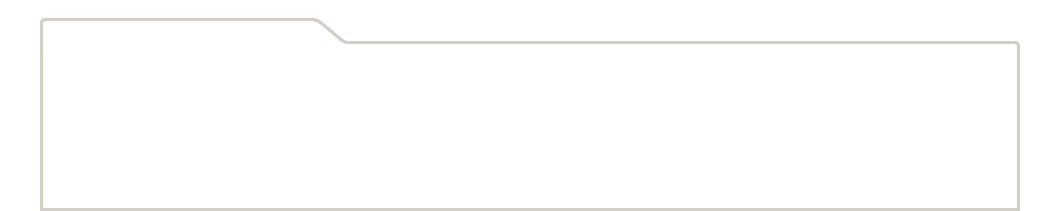
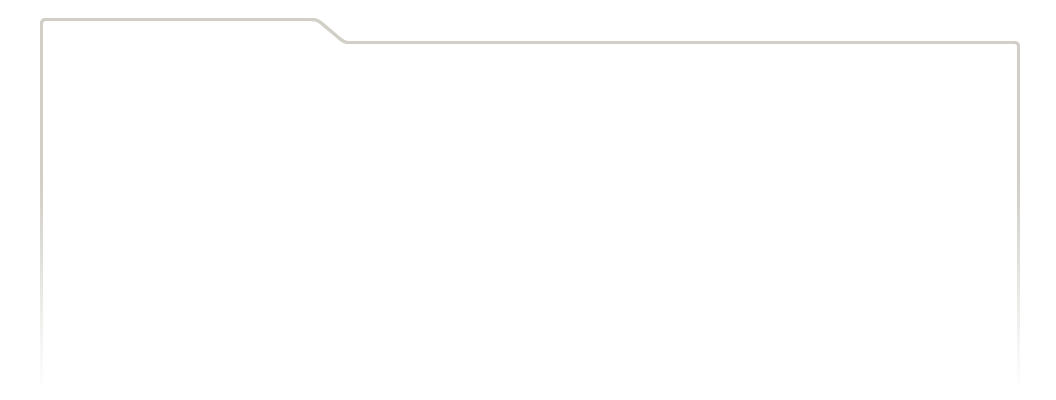
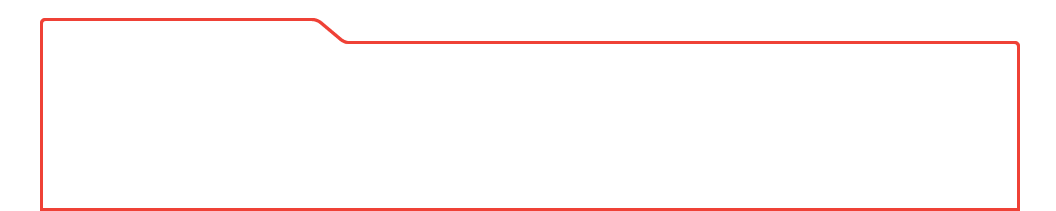
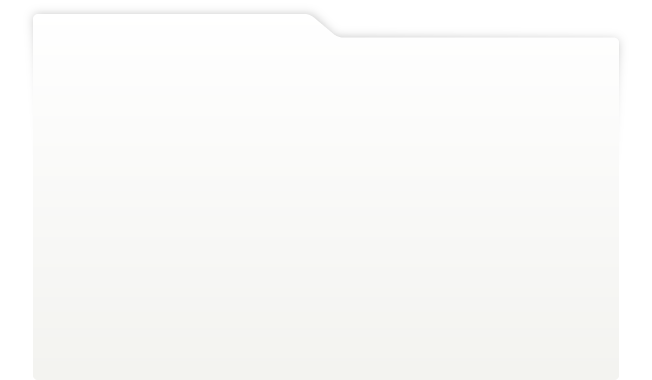
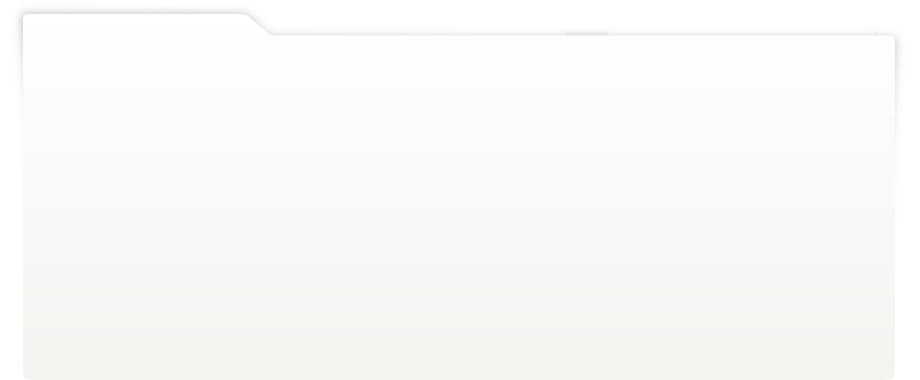
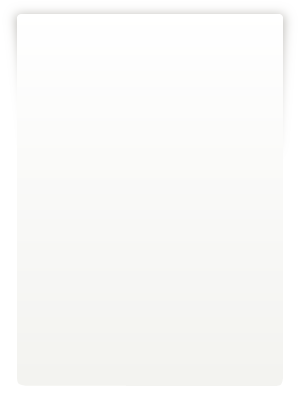
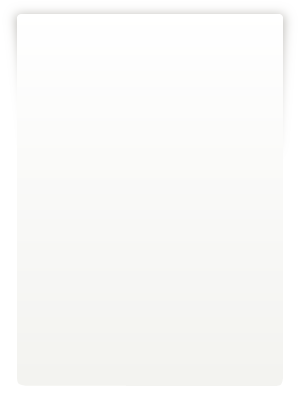
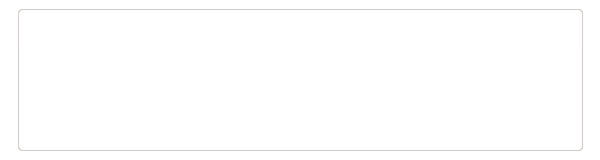
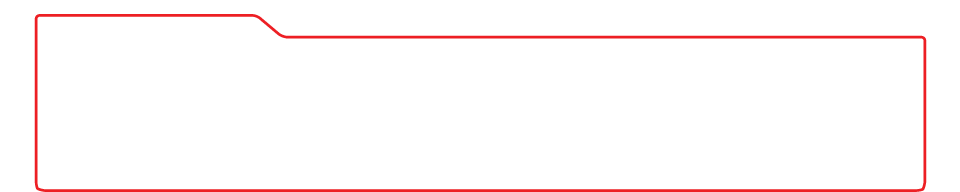
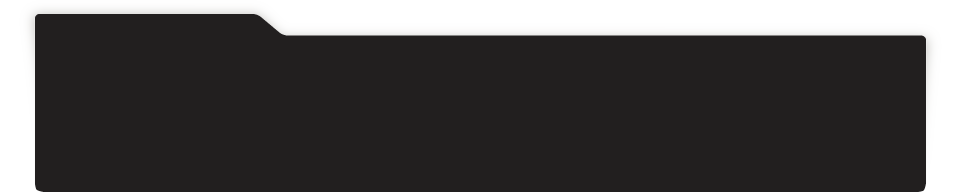
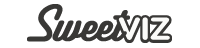
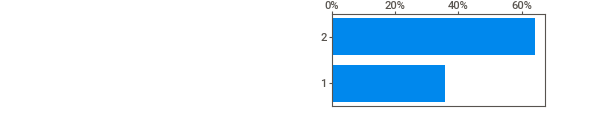
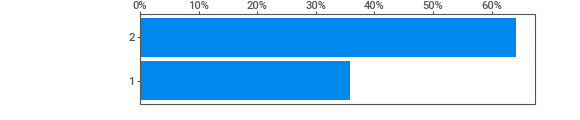
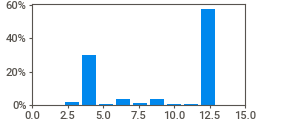
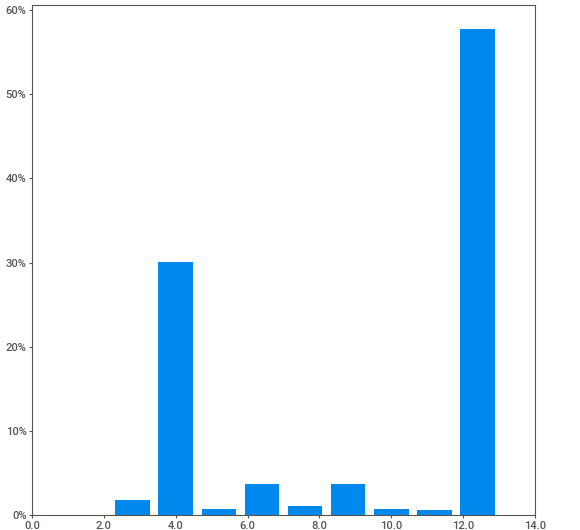
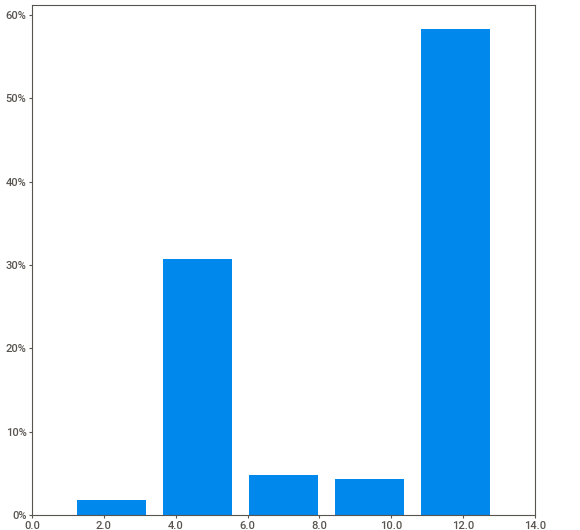
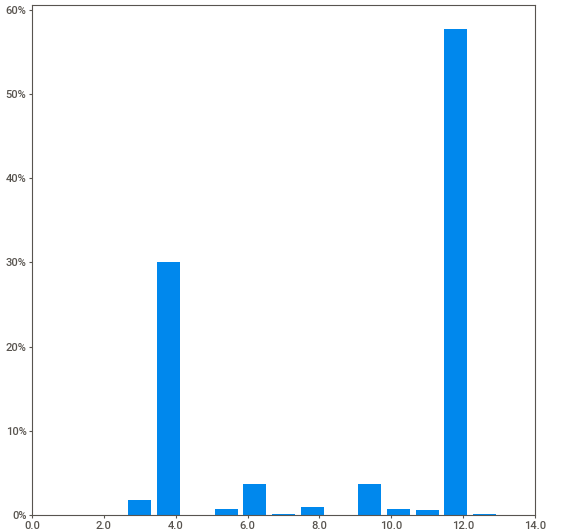
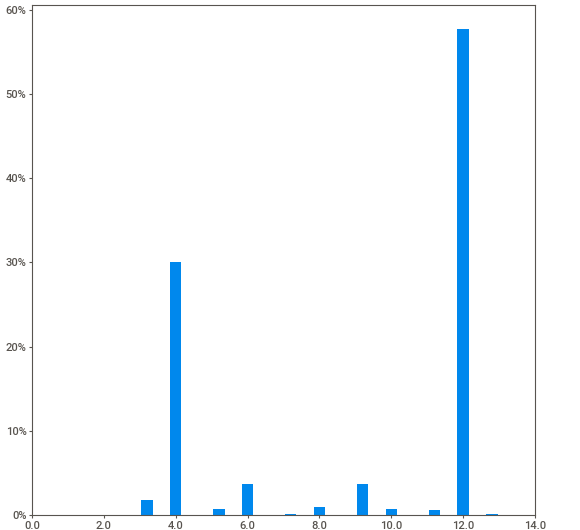
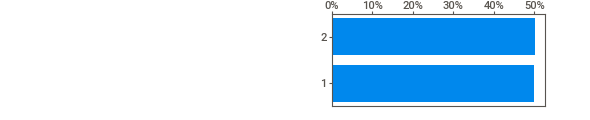
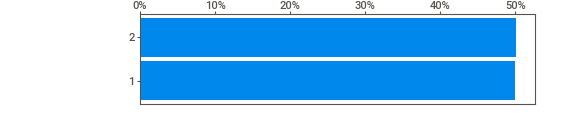
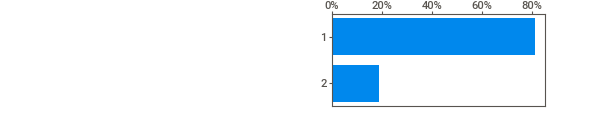
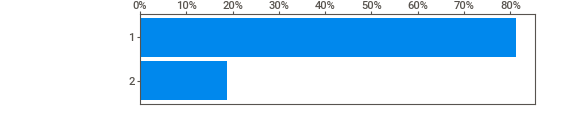
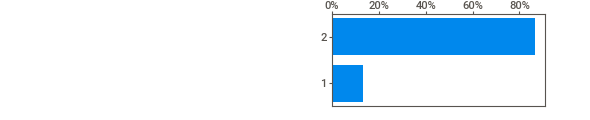
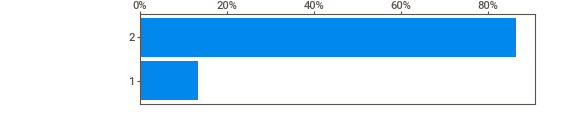
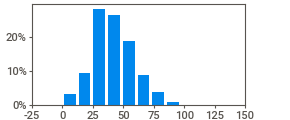
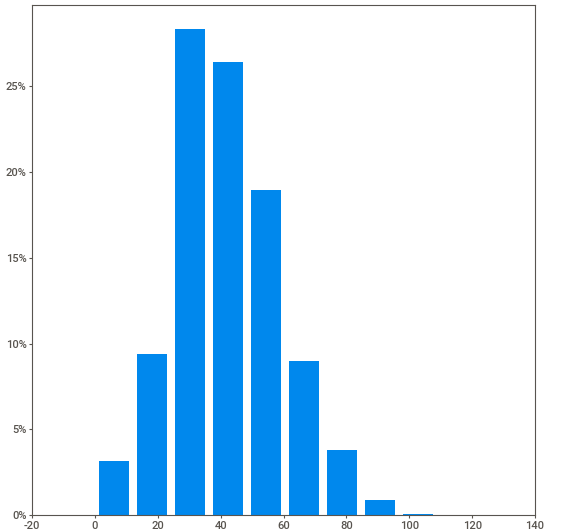
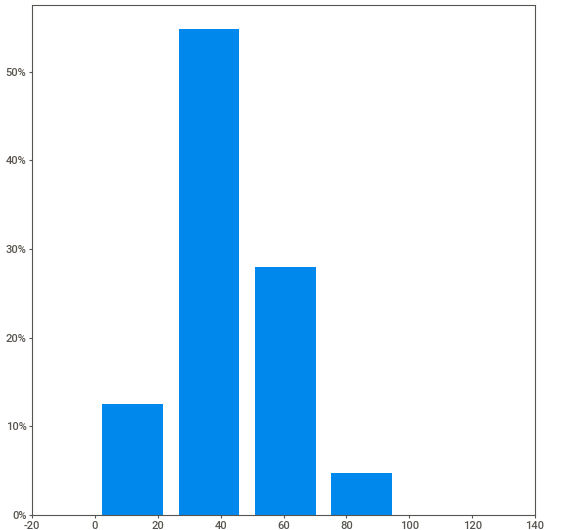
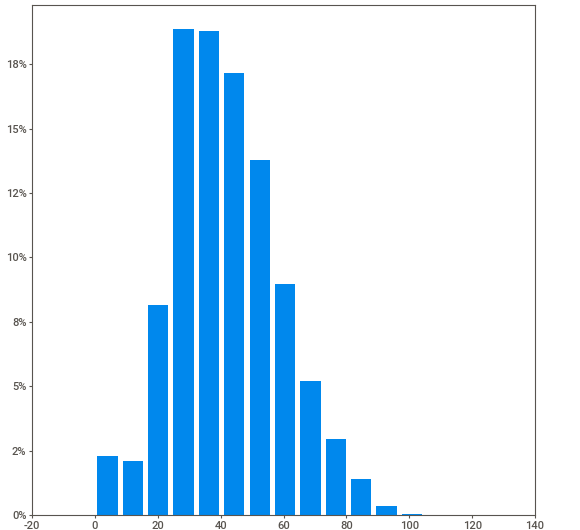
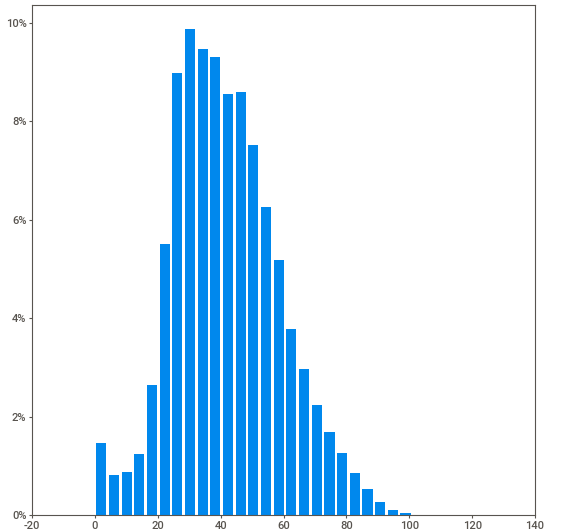
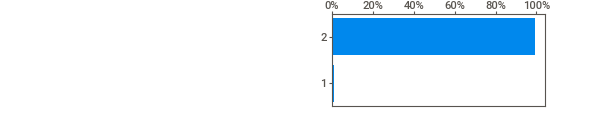
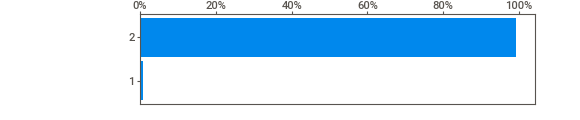
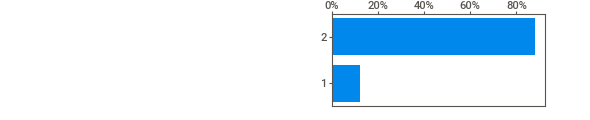
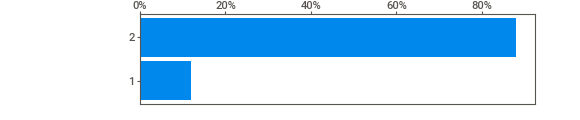
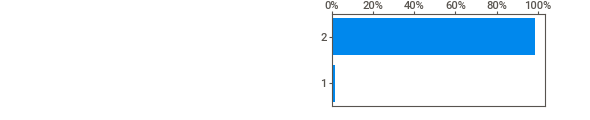
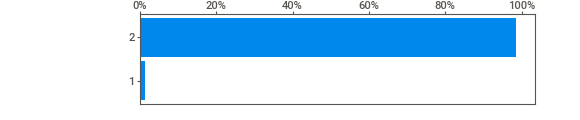
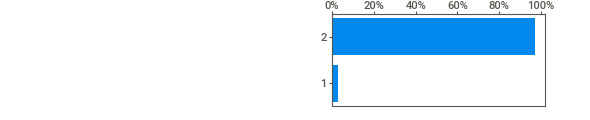
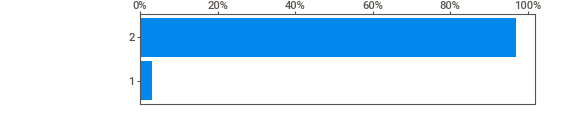
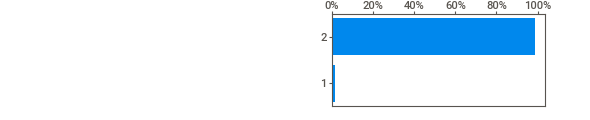
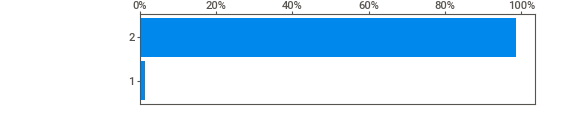
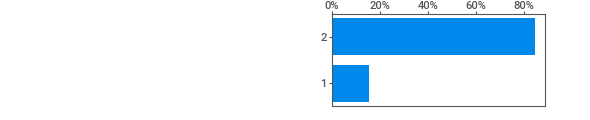
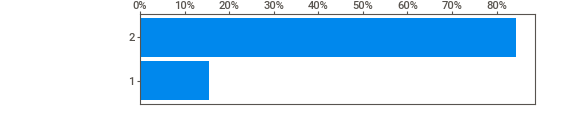
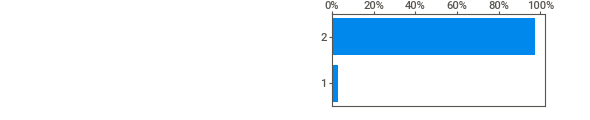
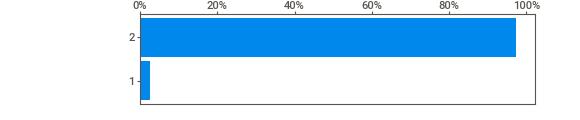
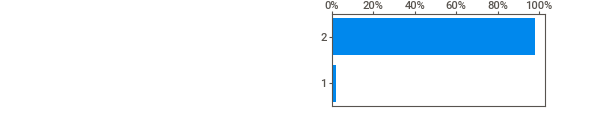
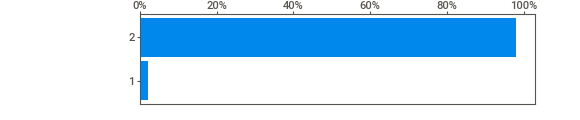
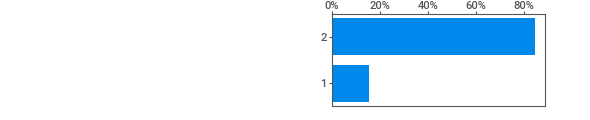
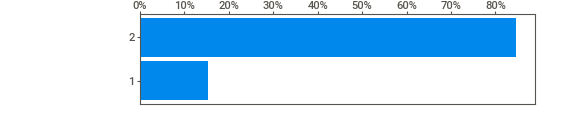
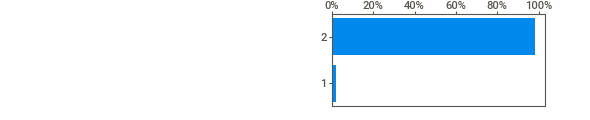
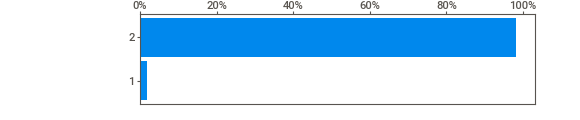
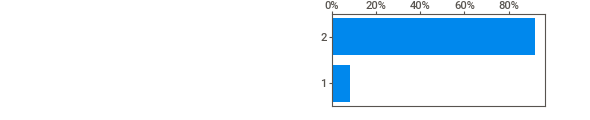
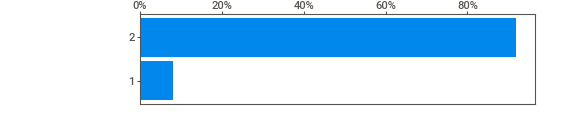
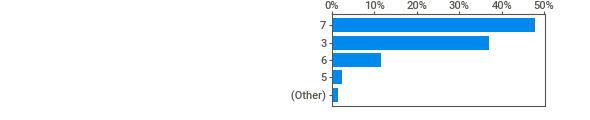
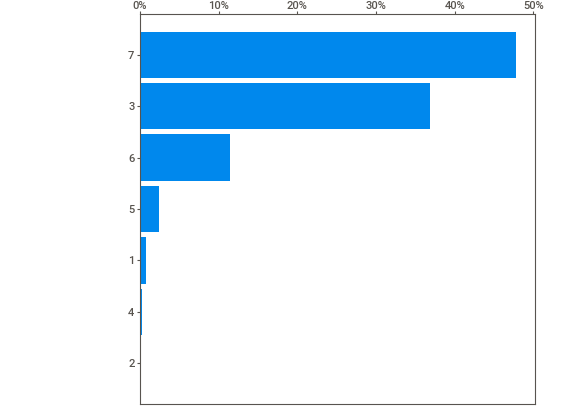
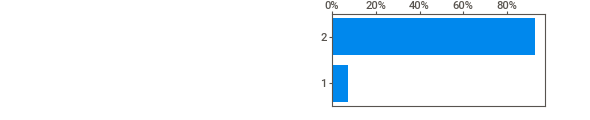
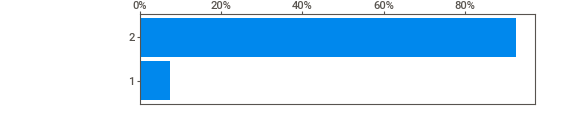
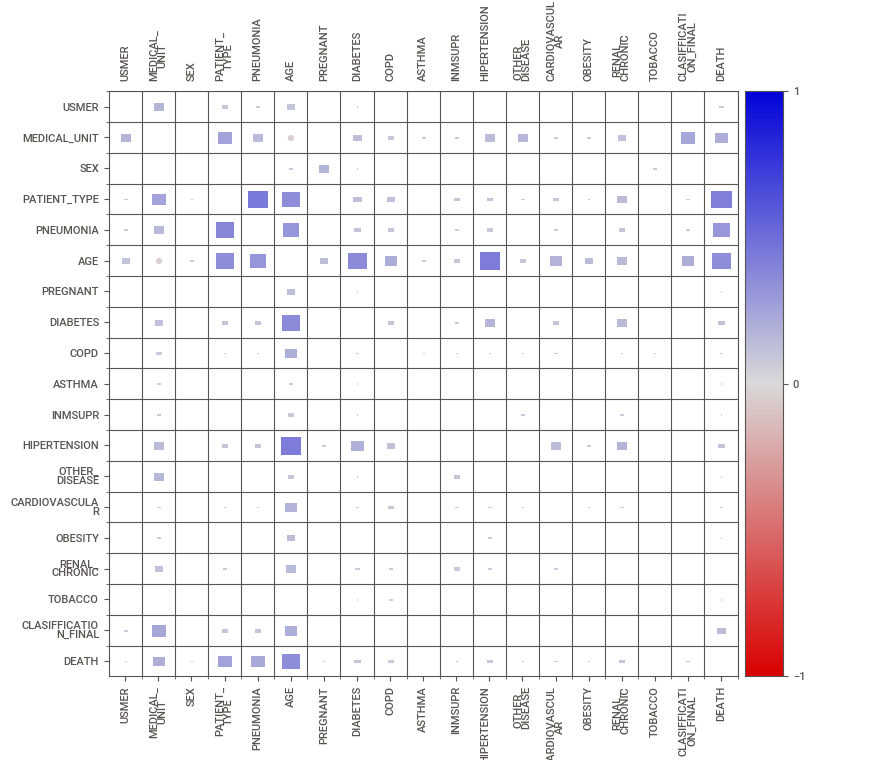
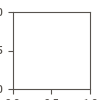

In [37]:
#Visualizing the notebook
report.show_notebook()

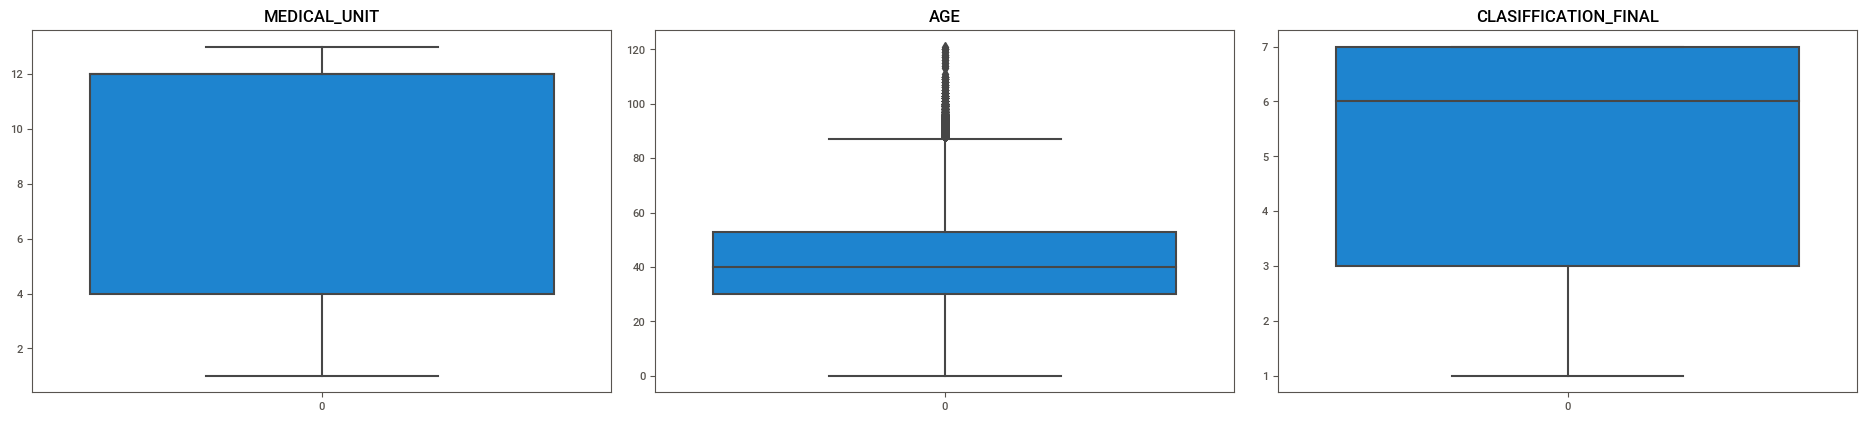

In [39]:
# plot for outliers detection

plt.figure(figsize=(25,20))
for i in range(len(num_cols)):
    plt.subplot(5,4,i+1)
    sns.boxplot(df[num_cols[i]])
    plt.title(num_cols[i])

plt.tight_layout()

In [40]:
#let us numerically draw conclusions
#creating function that can calculate interquartile range of the data
def calc_interquartile(data, column):
    global lower, upper
    #calculating the first and third quartile
    first_quartile, third_quartile = np.percentile(data[column], 25), np.percentile(data[column], 75)
    #calculate the interquartilerange
    iqr = third_quartile - first_quartile
    # outlier cutoff (1.5 is a generally taken as a threshold thats why i am also taking it)
    cutoff = iqr*1.5
    #calculate the lower and upper limits
    lower, upper = first_quartile - cutoff , third_quartile + cutoff
    #remove the outliers from the columns
    upper_outliers = data[data[column] > upper]
    lower_outliers = data[data[column] < lower]
    print('Lower outliers', lower_outliers.shape[0])
    print('Upper outliers', upper_outliers.shape[0])
    return print('total outliers', upper_outliers.shape[0] + lower_outliers.shape[0])


Total outliers in  MEDICAL_UNIT
Lower outliers 0
Upper outliers 0
total outliers 0
24.0 -8.0


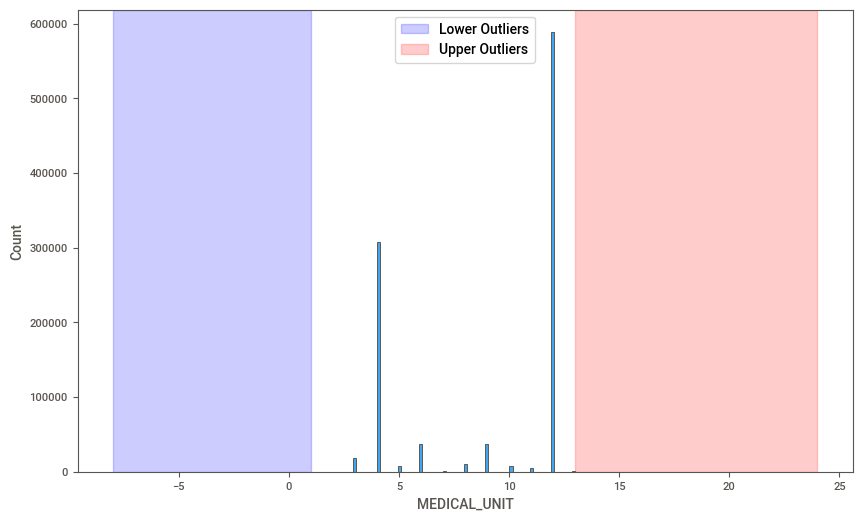

Total outliers in  AGE
Lower outliers 0
Upper outliers 5323
total outliers 5323
87.5 -4.5


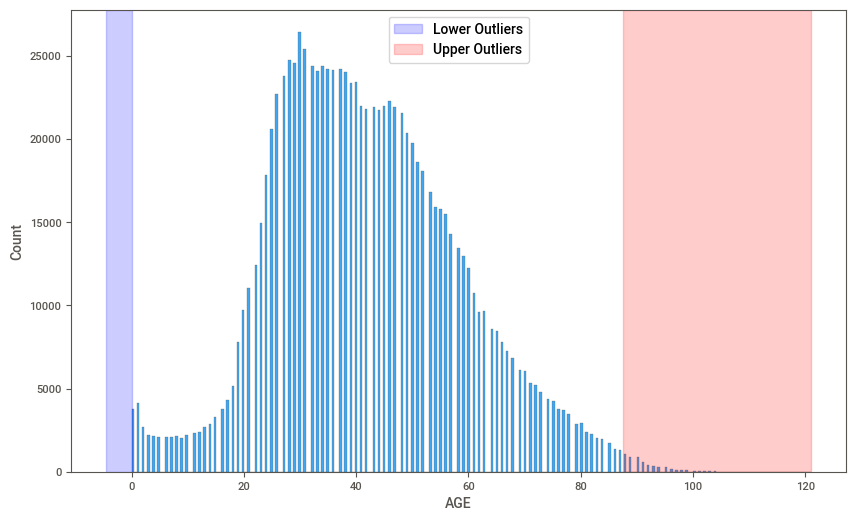

Total outliers in  CLASIFFICATION_FINAL
Lower outliers 0
Upper outliers 0
total outliers 0
13.0 -3.0


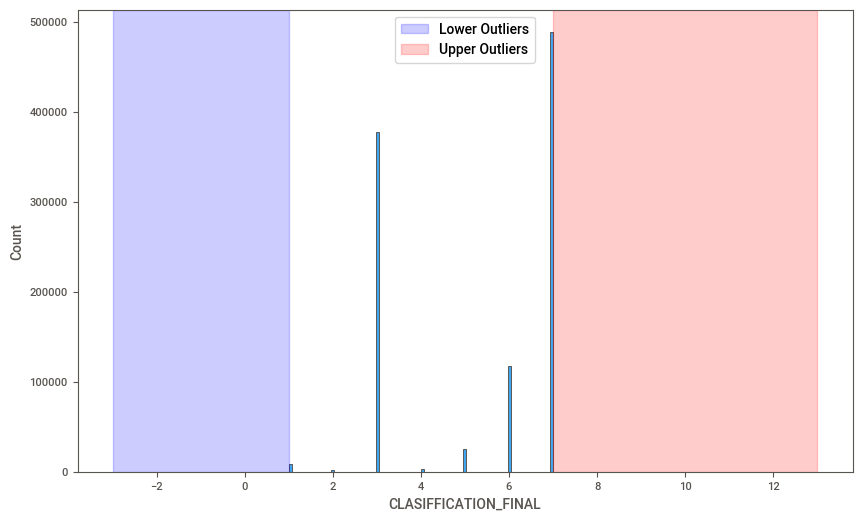

In [41]:
#plotting outliers graph for each feature
#for  col in df.select_dtypes('float'):
for  col in num_cols:
  print('Total outliers in ', col)
  calc_interquartile(df, col)
  plt.figure(figsize = (10,6))
  sns.histplot(df[col], kde=False)
  print(upper, lower)
  plt.axvspan(xmin = lower,xmax= df[col].min(),alpha=0.2, color='blue', label='Lower Outliers')
  plt.axvspan(xmin = upper,xmax= df[col].max(),alpha=0.2, color='red', label='Upper Outliers')
  plt.legend()
  plt.show()

In [42]:
# General Exploration for Categorical Variables:

def cat_summary(dataframe, plot=False):
    for col_name in cat_cols:
        print("############## Unique Observations of Categorical Data ###############")
        print("The unique number of "+ col_name+": "+ str(dataframe[col_name].nunique()))

        print("############## Frequency of Categorical Data ########################")
        print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                            "Ratio": dataframe[col_name].value_counts()/len(dataframe)}))
        if plot == True:
            rgb_values = sns.color_palette("Set2", 6)
            sns.set_theme(style="darkgrid")
            ax = sns.countplot(x=dataframe[col_name], data=dataframe, palette=rgb_values)
            for p in ax.patches:
                ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)
            plt.show()

############## Unique Observations of Categorical Data ###############
The unique number of USMER: 2
############## Frequency of Categorical Data ########################
    USMER     Ratio
2  656118  0.642009
1  365859  0.357991


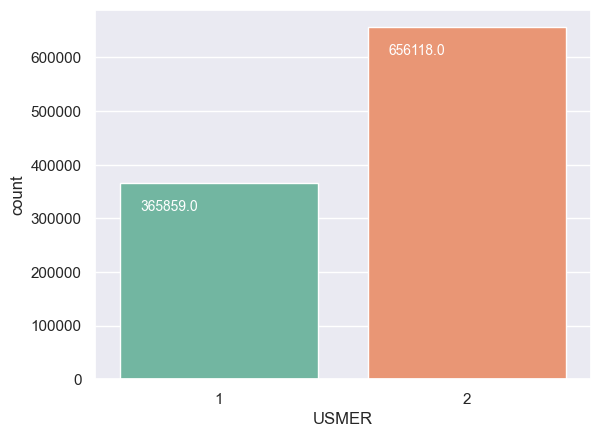

############## Unique Observations of Categorical Data ###############
The unique number of SEX: 2
############## Frequency of Categorical Data ########################
      SEX     Ratio
2  511936  0.500927
1  510041  0.499073


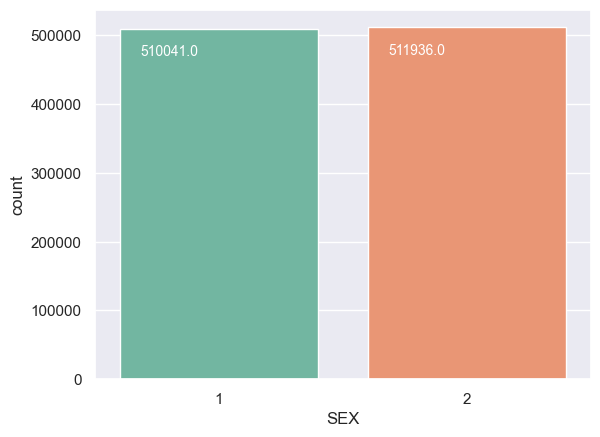

############## Unique Observations of Categorical Data ###############
The unique number of PATIENT_TYPE: 2
############## Frequency of Categorical Data ########################
   PATIENT_TYPE     Ratio
1        830385  0.812528
2        191592  0.187472


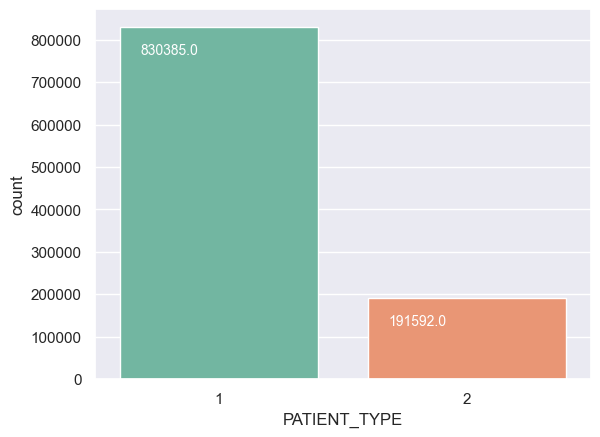

############## Unique Observations of Categorical Data ###############
The unique number of PNEUMONIA: 2
############## Frequency of Categorical Data ########################
   PNEUMONIA     Ratio
2     884614  0.865591
1     137363  0.134409


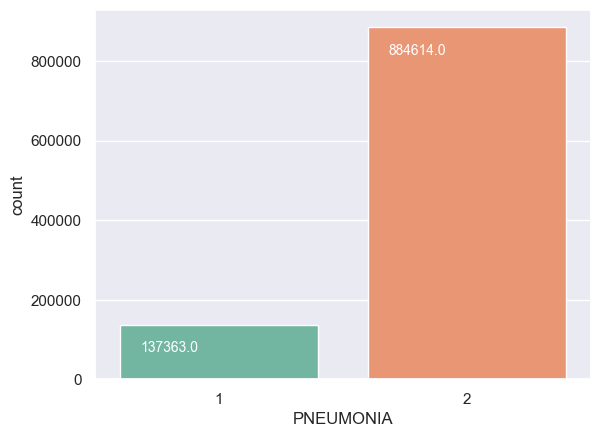

############## Unique Observations of Categorical Data ###############
The unique number of PREGNANT: 2
############## Frequency of Categorical Data ########################
   PREGNANT     Ratio
2   1014136  0.992328
1      7841  0.007672


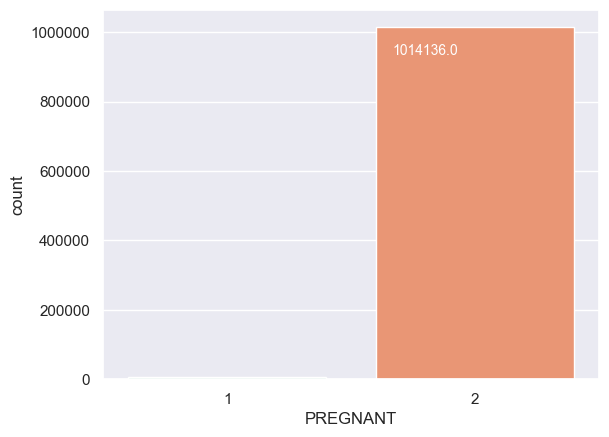

############## Unique Observations of Categorical Data ###############
The unique number of DIABETES: 2
############## Frequency of Categorical Data ########################
   DIABETES     Ratio
2    899805  0.880455
1    122172  0.119545


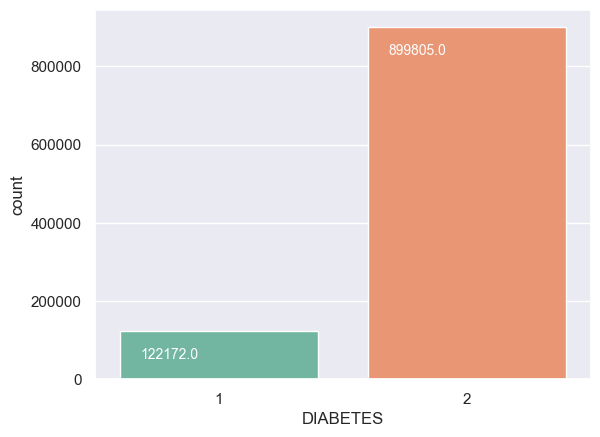

############## Unique Observations of Categorical Data ###############
The unique number of COPD: 2
############## Frequency of Categorical Data ########################
      COPD     Ratio
2  1007619  0.985951
1    14358  0.014049


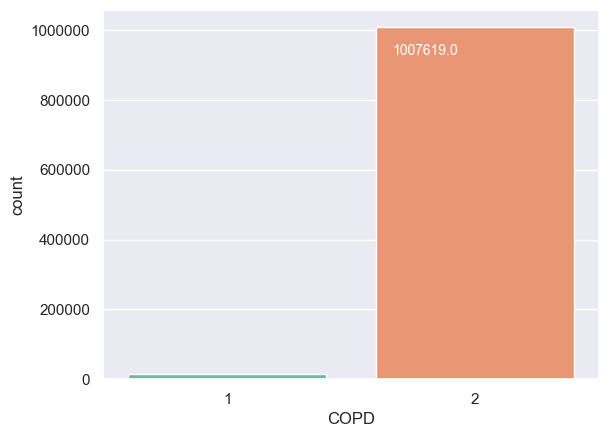

############## Unique Observations of Categorical Data ###############
The unique number of ASTHMA: 2
############## Frequency of Categorical Data ########################
   ASTHMA     Ratio
2  991561  0.970238
1   30416  0.029762


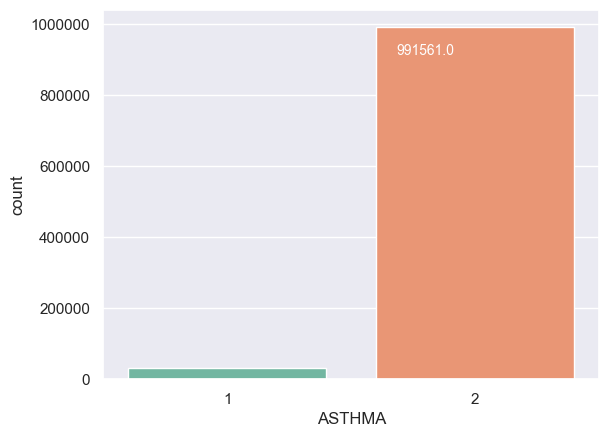

############## Unique Observations of Categorical Data ###############
The unique number of INMSUPR: 2
############## Frequency of Categorical Data ########################
   INMSUPR     Ratio
2  1008419  0.986734
1    13558  0.013266


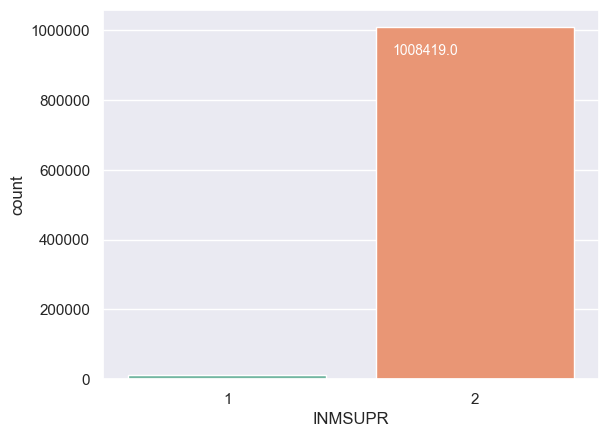

############## Unique Observations of Categorical Data ###############
The unique number of HIPERTENSION: 2
############## Frequency of Categorical Data ########################
   HIPERTENSION     Ratio
2        862715  0.844163
1        159262  0.155837


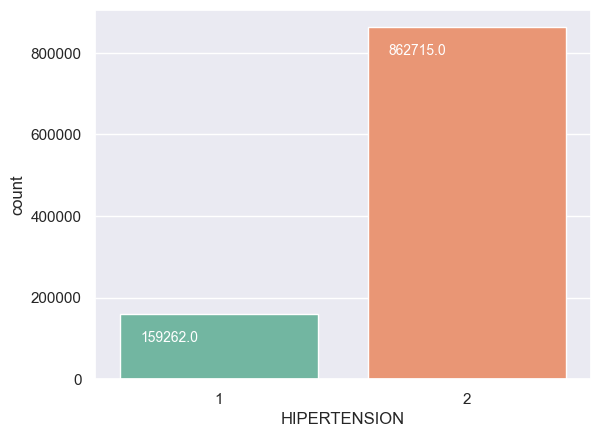

############## Unique Observations of Categorical Data ###############
The unique number of OTHER_DISEASE: 2
############## Frequency of Categorical Data ########################
   OTHER_DISEASE     Ratio
2         994893  0.973498
1          27084  0.026502


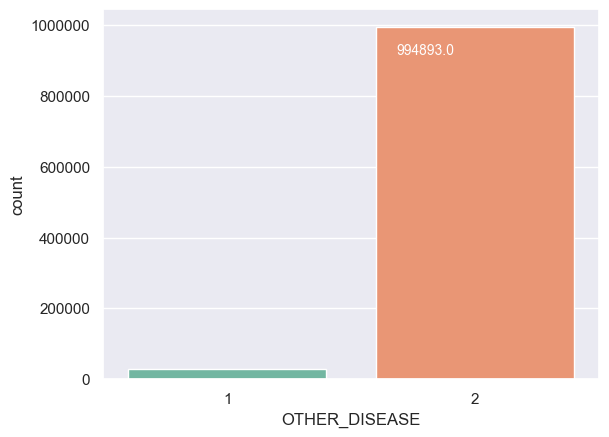

############## Unique Observations of Categorical Data ###############
The unique number of CARDIOVASCULAR: 2
############## Frequency of Categorical Data ########################
   CARDIOVASCULAR     Ratio
2         1001891  0.980346
1           20086  0.019654


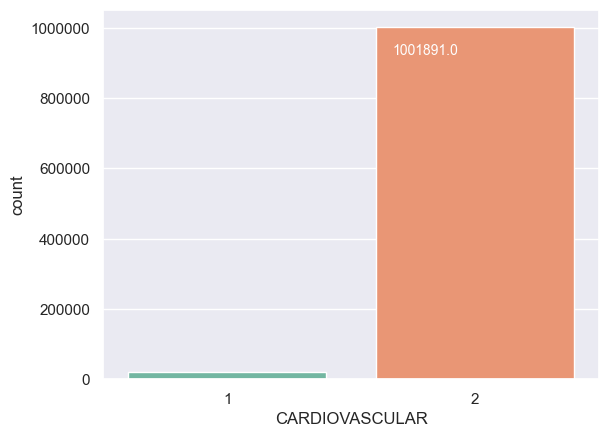

############## Unique Observations of Categorical Data ###############
The unique number of OBESITY: 2
############## Frequency of Categorical Data ########################
   OBESITY     Ratio
2   865383  0.846773
1   156594  0.153227


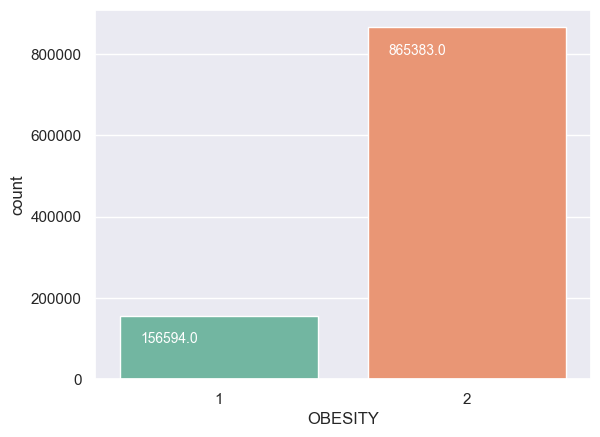

############## Unique Observations of Categorical Data ###############
The unique number of RENAL_CHRONIC: 2
############## Frequency of Categorical Data ########################
   RENAL_CHRONIC     Ratio
2        1003657  0.982074
1          18320  0.017926


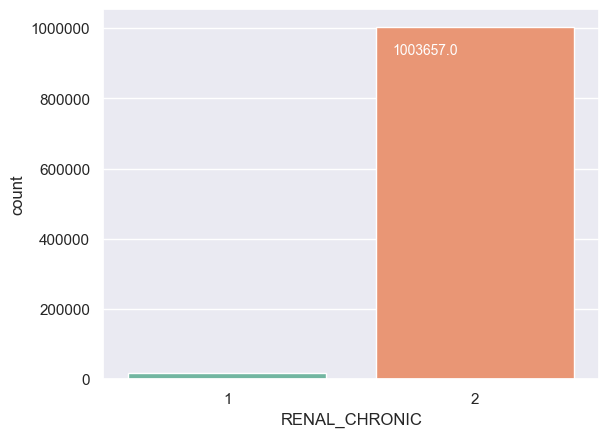

############## Unique Observations of Categorical Data ###############
The unique number of TOBACCO: 2
############## Frequency of Categorical Data ########################
   TOBACCO     Ratio
2   939439  0.919237
1    82538  0.080763


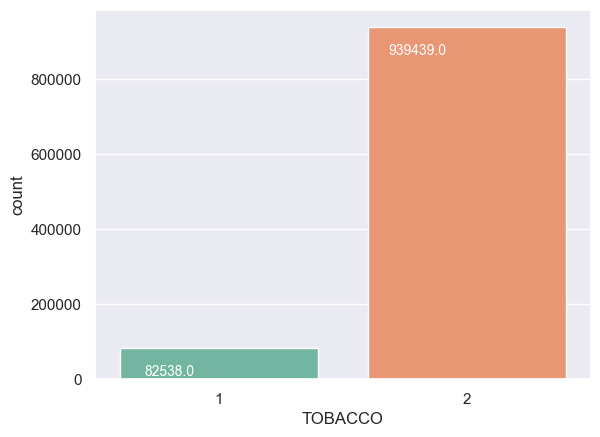

############## Unique Observations of Categorical Data ###############
The unique number of DEATH: 2
############## Frequency of Categorical Data ########################
    DEATH     Ratio
2  947320  0.926948
1   74657  0.073052


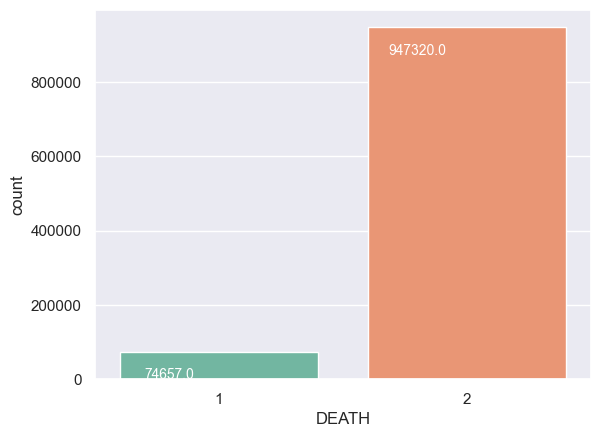

In [43]:
cat_summary(df, plot=True)

Nous constatons une ambivalance pour la majeur partie des variable. cela risque de biaiser notre modèle. 

In [44]:
# General Exploration for Numerical Variables:

def num_summary(dataframe,  plot=False):
    quantiles = [0.25, 0.50, 0.75, 1]
    for col_name in num_cols:
        print("########## Summary Statistics of " +  col_name + " ############")
        print(dataframe[col_name].describe(quantiles).T)

        if plot:
            sns.histplot(data=dataframe, x=col_name  )
            plt.xlabel(col_name)
            plt.title("The distribution of "+ col_name)
            plt.grid(True)
            plt.show(block=True)

########## Summary Statistics of MEDICAL_UNIT ############
count    1.021977e+06
mean     8.987361e+00
std      3.724244e+00
min      1.000000e+00
25%      4.000000e+00
50%      1.200000e+01
75%      1.200000e+01
100%     1.300000e+01
max      1.300000e+01
Name: MEDICAL_UNIT, dtype: float64


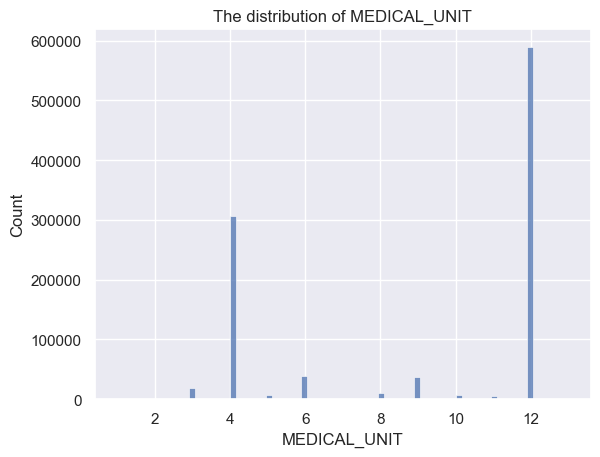

########## Summary Statistics of AGE ############
count    1.021977e+06
mean     4.189535e+01
std      1.674953e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.000000e+01
75%      5.300000e+01
100%     1.210000e+02
max      1.210000e+02
Name: AGE, dtype: float64


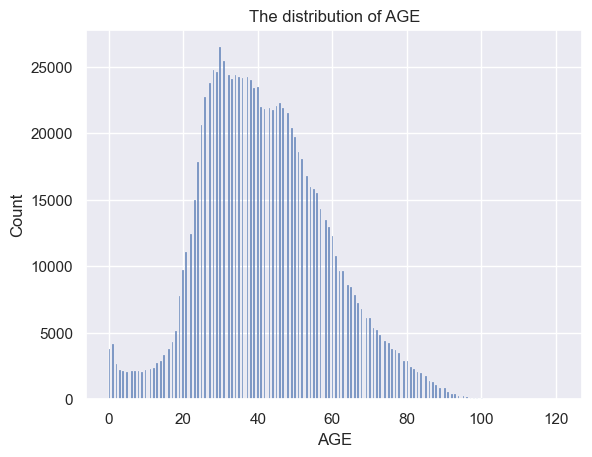

########## Summary Statistics of CLASIFFICATION_FINAL ############
count    1.021977e+06
mean     5.291434e+00
std      1.889546e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      7.000000e+00
100%     7.000000e+00
max      7.000000e+00
Name: CLASIFFICATION_FINAL, dtype: float64


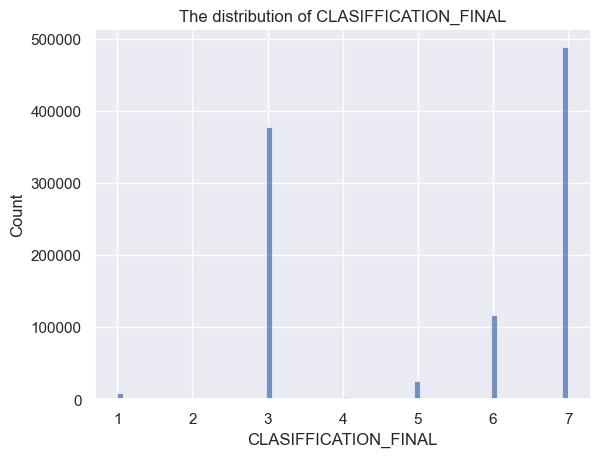

In [45]:
num_summary(df, plot=True)

### Relation Target / Variables

In [46]:
DEATH_df = df[df['DEATH'] == 1]
notDEATH_df = df[df['DEATH'] == 2]

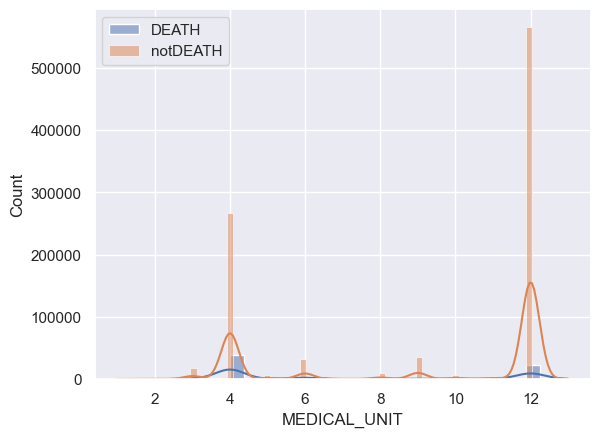

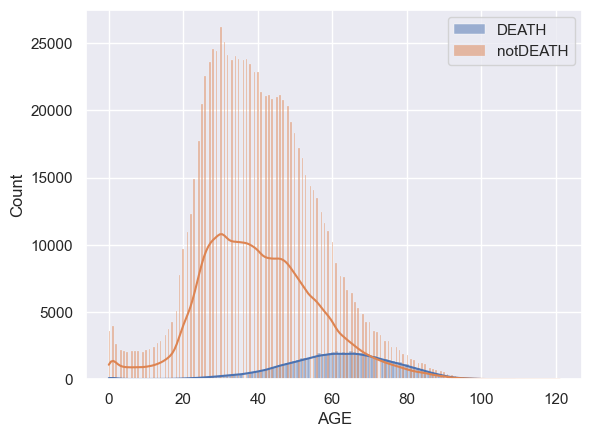

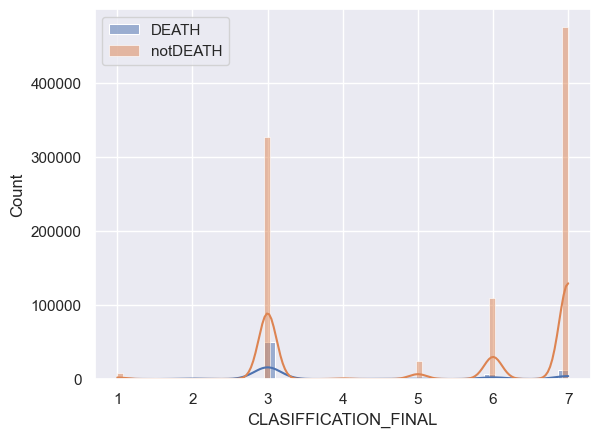

In [47]:
for col in num_cols:
    plt.figure()
    sns.histplot(DEATH_df[col], label='DEATH',kde=True)
    sns.histplot(notDEATH_df[col], label='notDEATH',kde=True)
    plt.legend()

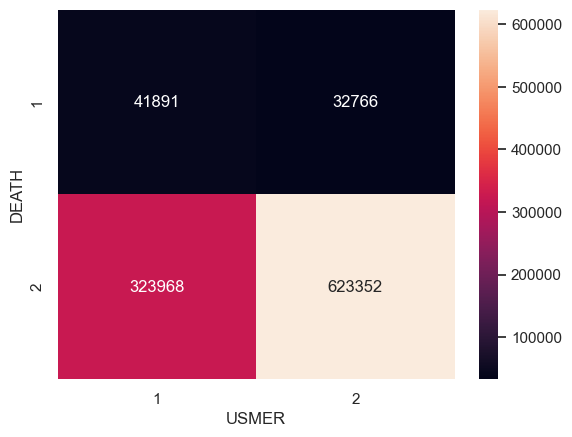

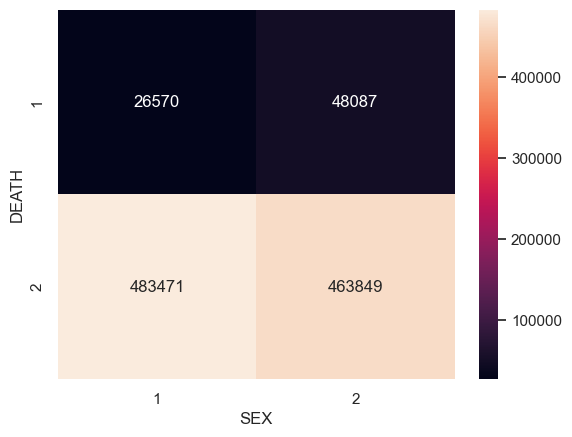

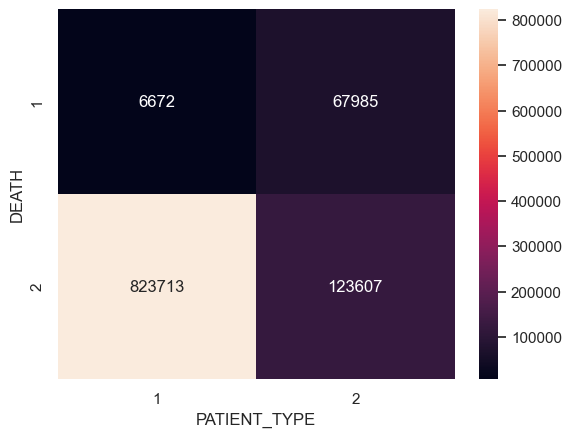

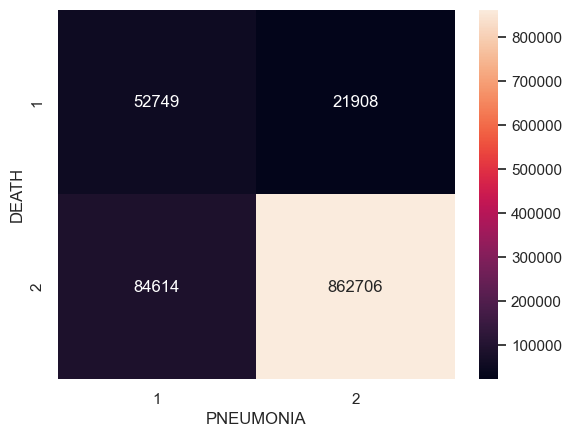

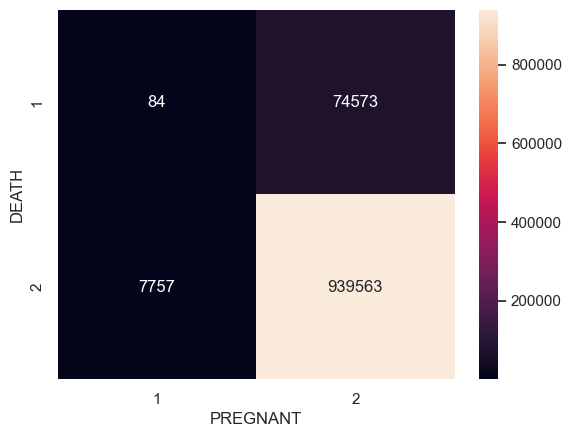

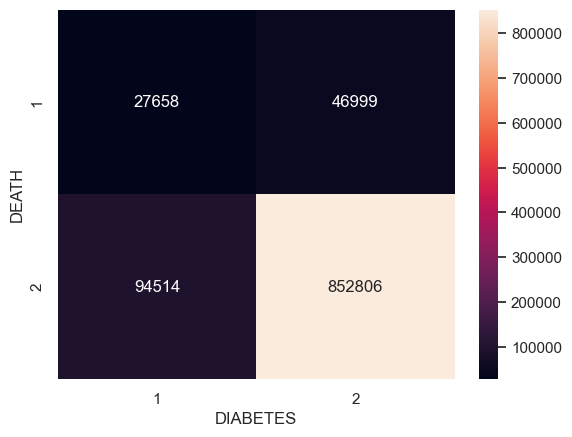

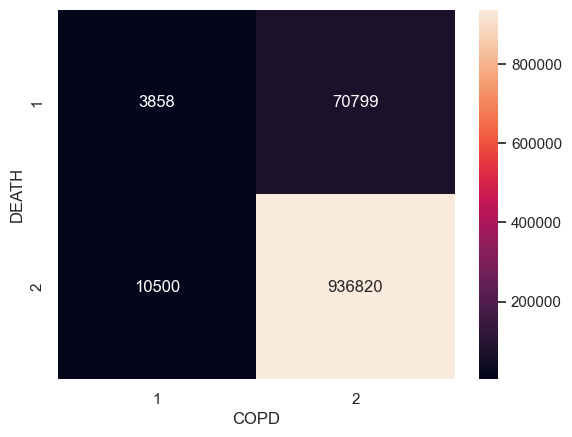

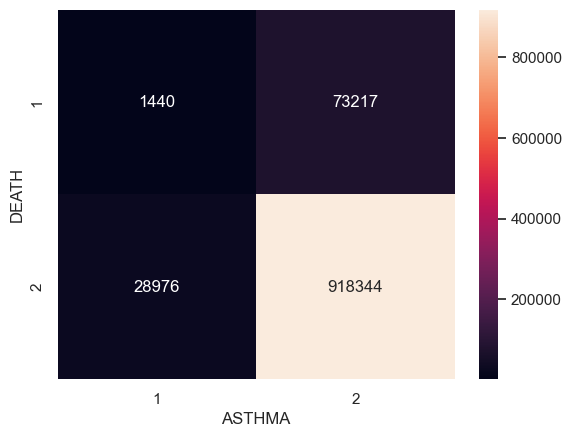

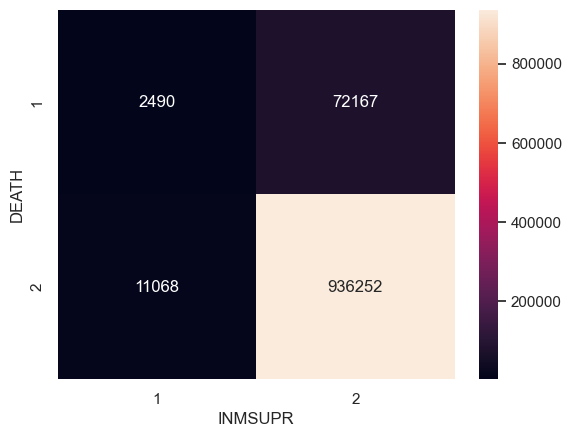

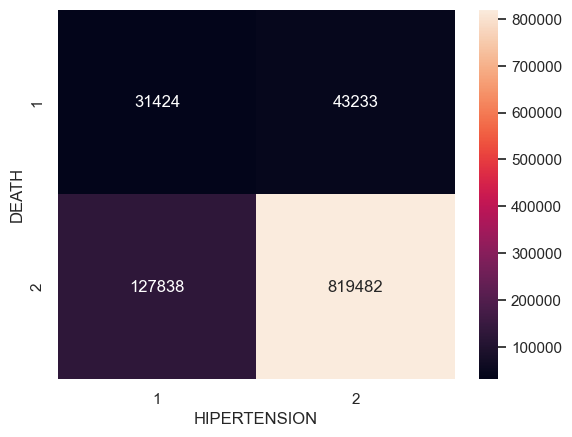

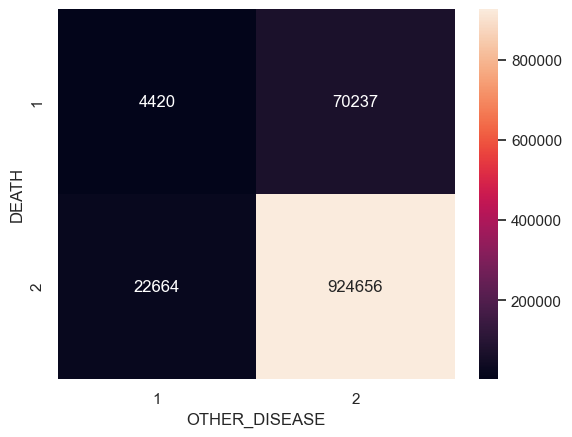

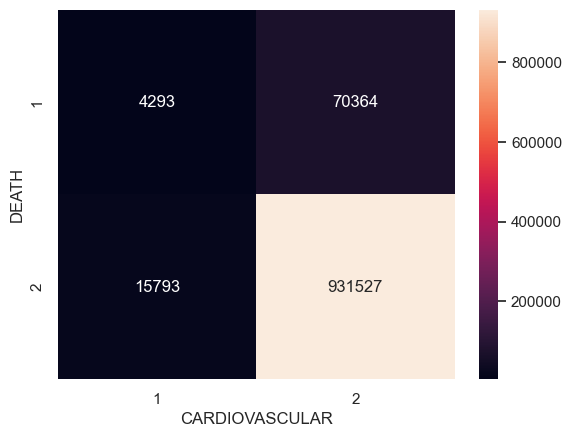

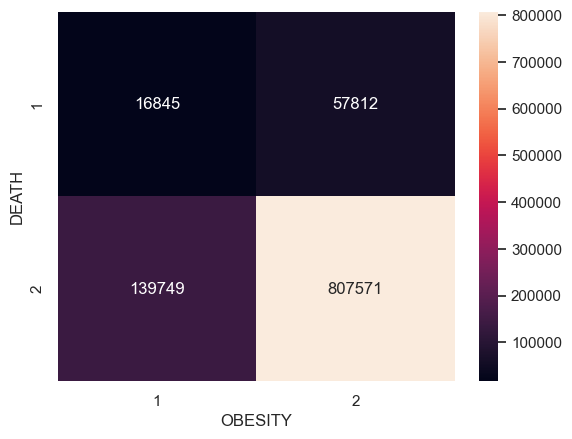

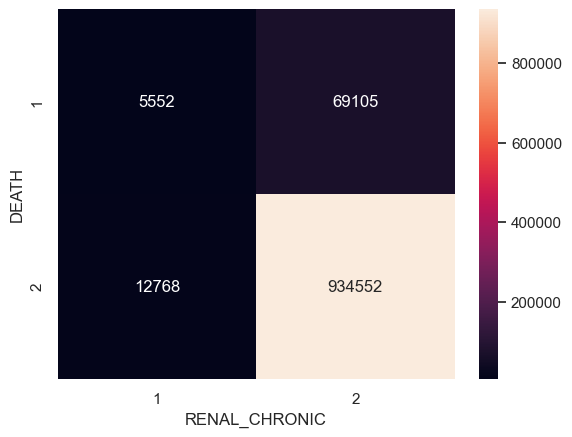

In [48]:
# Relation Target / categoricals variables
for col in cat_cols[:14]:
    plt.figure()
    sns.heatmap(pd.crosstab(df['DEATH'], df[col]), annot=True, fmt='d')

In [50]:
def plot_bar(df, feat_x, feat_y, normalize=True):
    """ Plot with vertical bars of the requested dataframe and features"""

    ct = pd.crosstab(df[feat_x], df[feat_y])
    if normalize == True:
        ct = ct.div(ct.sum(axis=1), axis=0)
    return ct.plot(kind='bar', stacked=True)

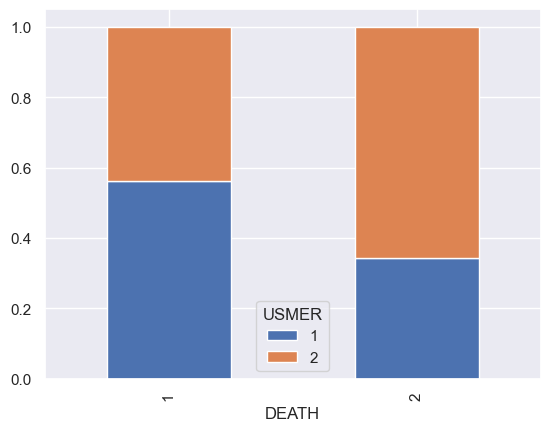

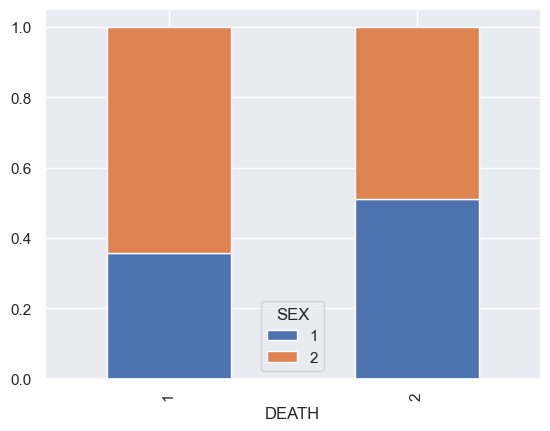

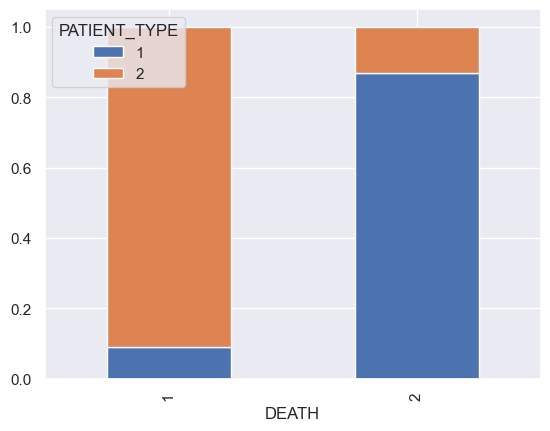

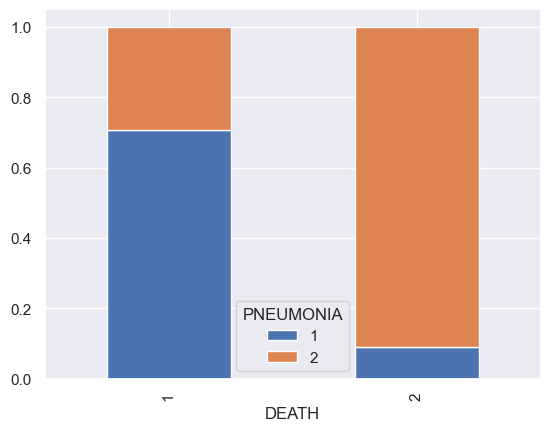

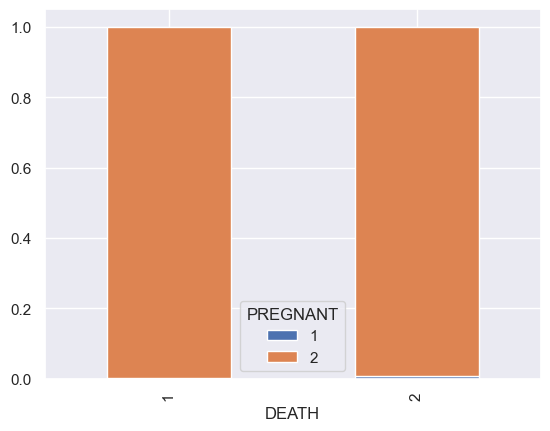

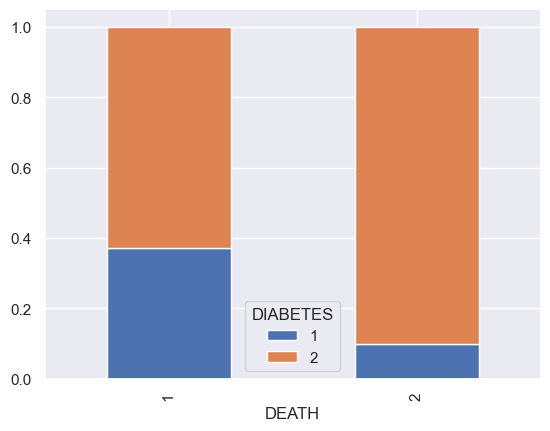

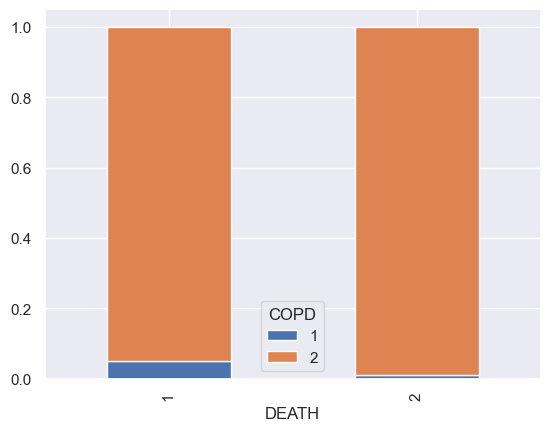

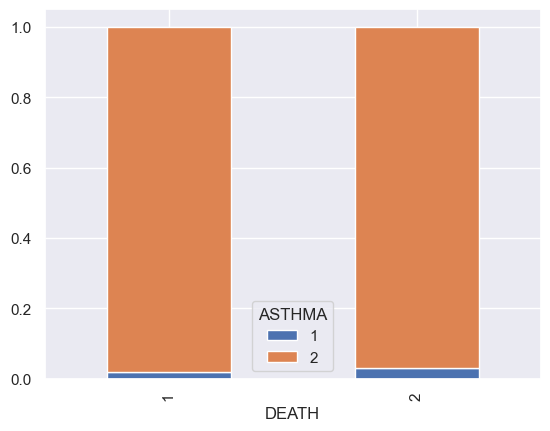

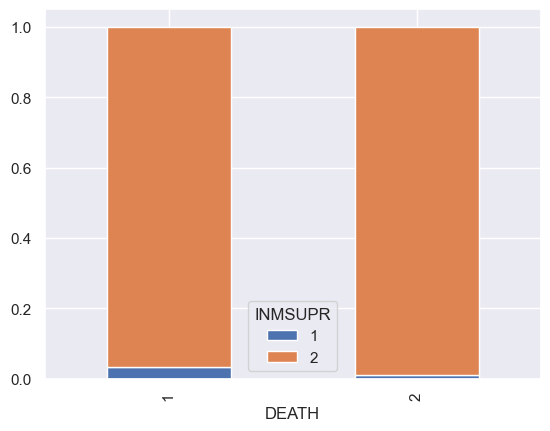

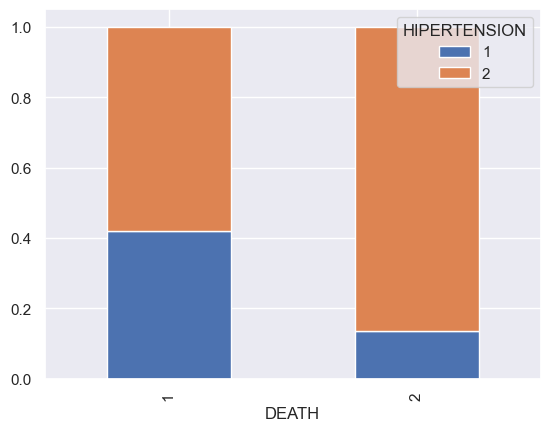

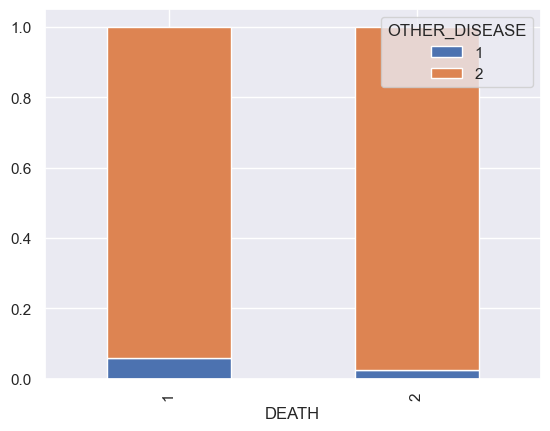

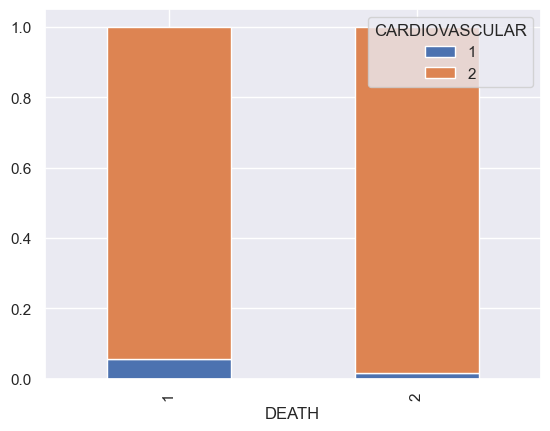

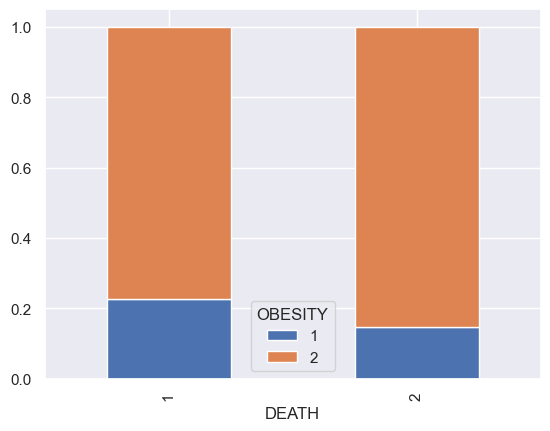

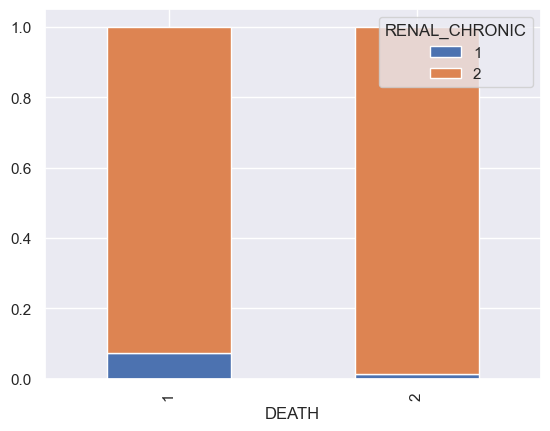

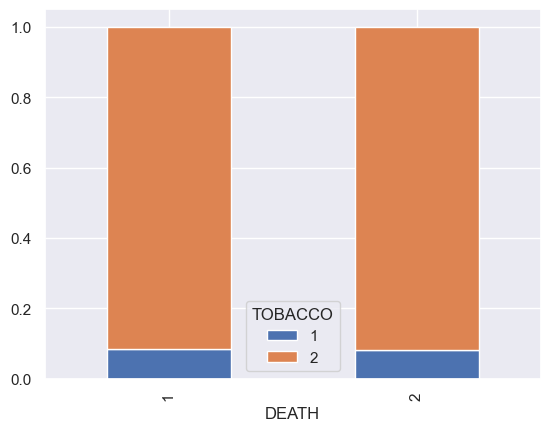

In [51]:
ll= cat_cols[:]
ll.remove('DEATH')
for c in ll:
  plot_bar(df,'DEATH', c )
  plt.show()


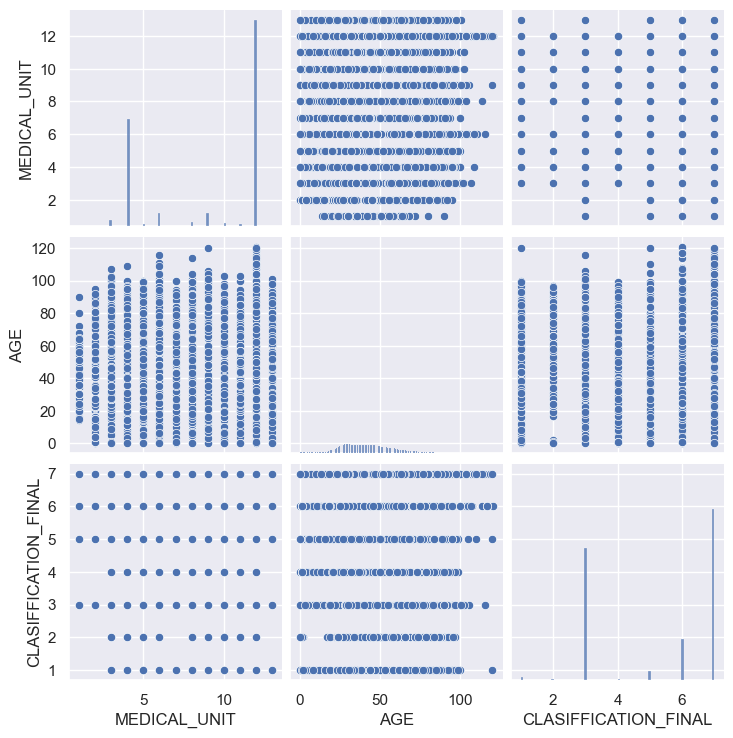

In [52]:
#Relation Variables / Variables
sns.pairplot(df[num_cols])

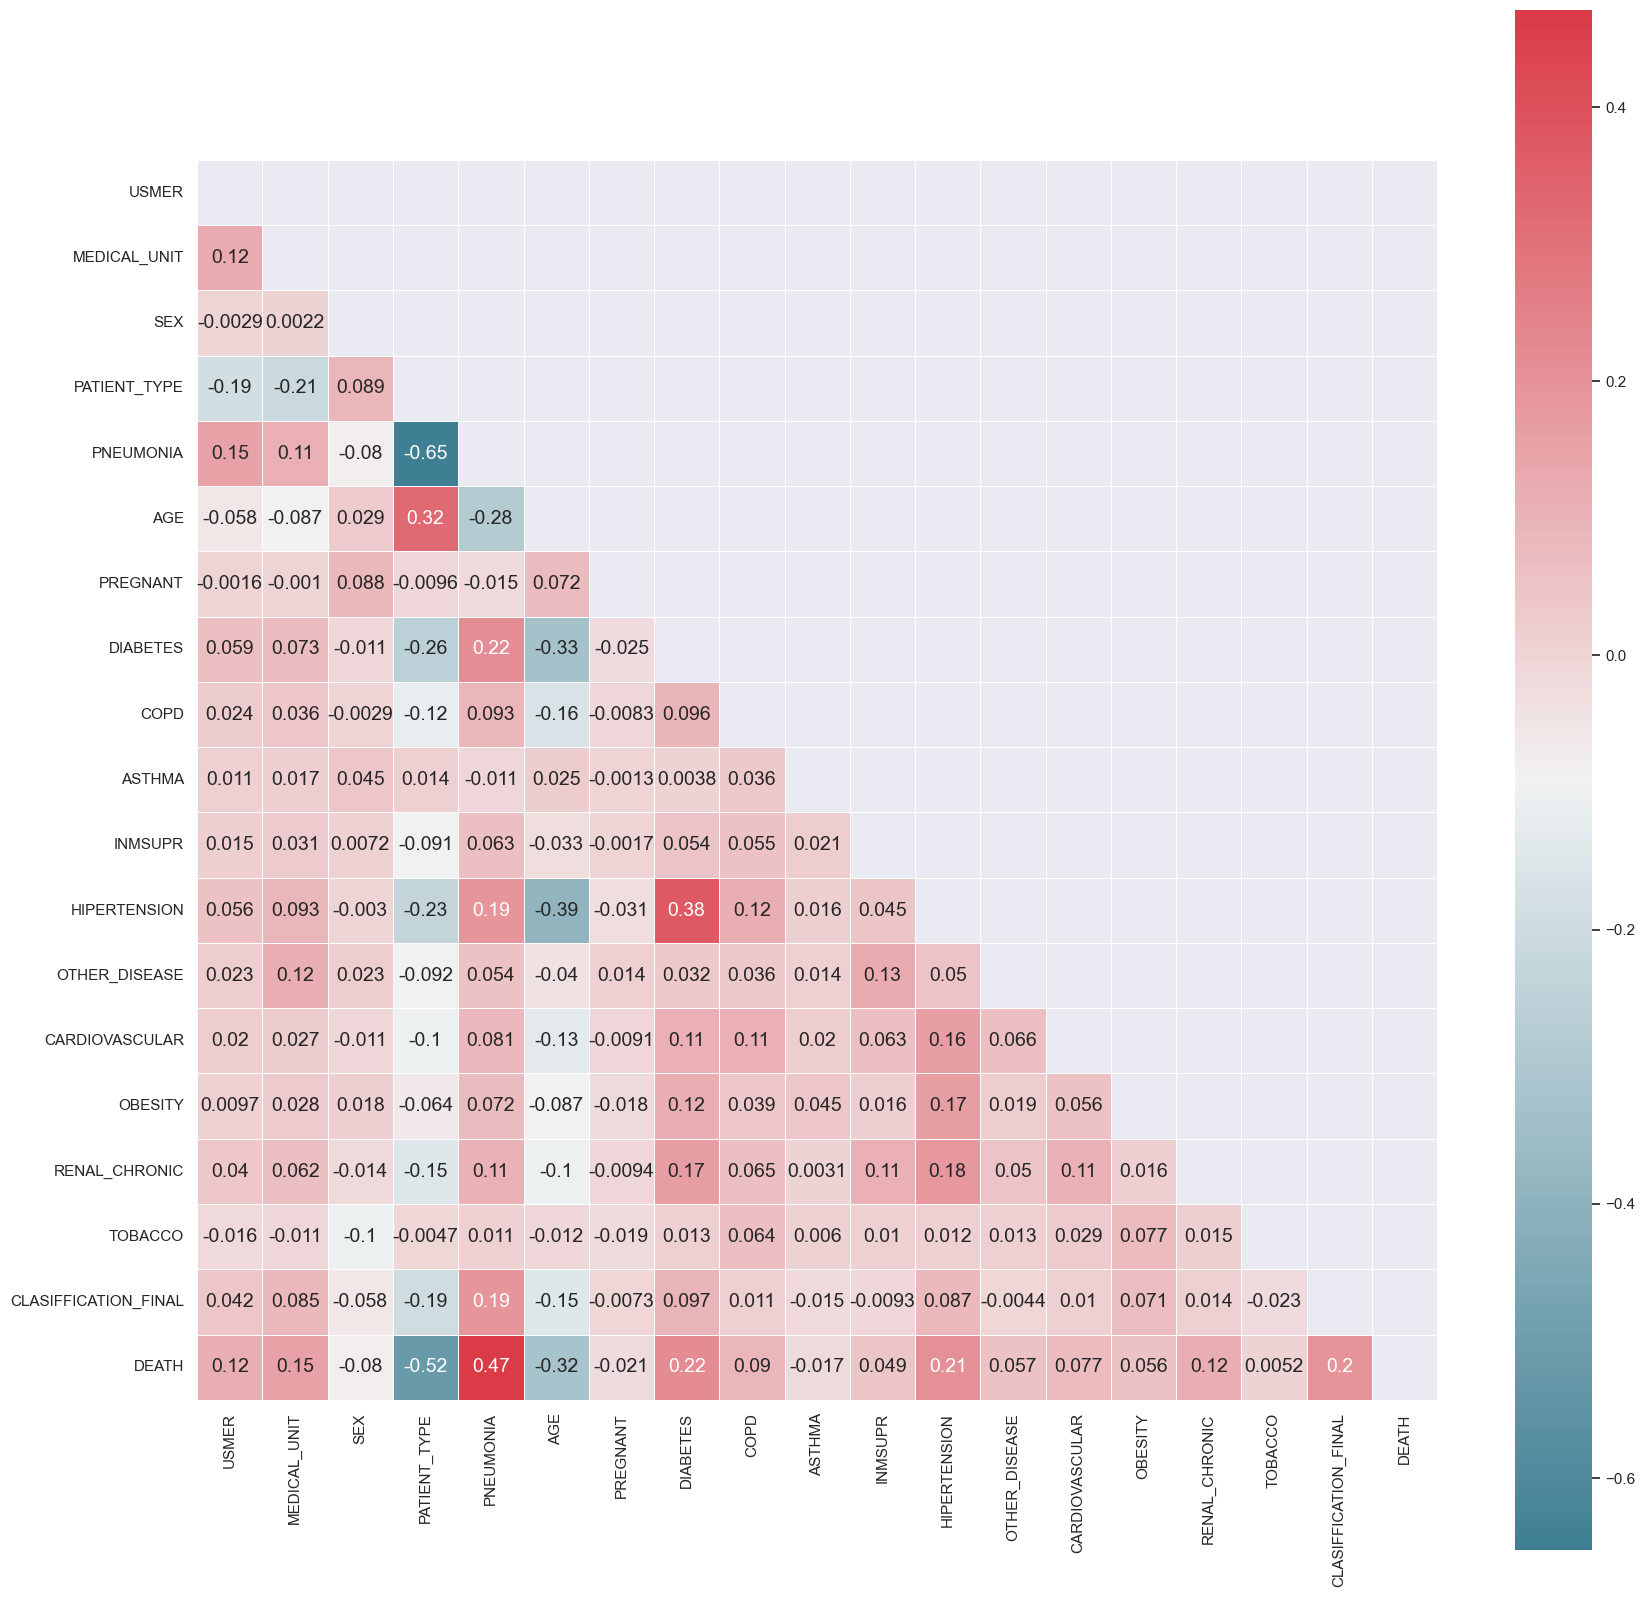

In [53]:
#Multivariate Analysis - Correlation Between Numerical Features
# calculates the correlations
correlation = df.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(20, 20)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=np.bool_))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlation, cmap=cmap, mask=mask, square=True, linewidths=.5,
            annot=True, annot_kws={'size':14})

# displays the plot
plt.show()

Je laisserai de côté les caractéristiques "SEX","PREGNANT","COPD","ASTHMA","INMSUPR","OTHER_DISEASE","CARDIOVASCULAR", "OBESITY","TOBACCO" car Ils ont une faible corrélation avec la caractéristique "DEATH"

### Selection de variable 

In [8]:
unrelevant_columns = ["SEX","PREGNANT","COPD","ASTHMA","INMSUPR","OTHER_DISEASE","CARDIOVASCULAR", "OBESITY","TOBACCO"]

df.drop(columns=unrelevant_columns,inplace=True)

In [11]:
df.head()

,USMER,MEDICAL_UNIT,PATIENT_TYPE,PNEUMONIA,AGE,DIABETES,HIPERTENSION,RENAL_CHRONIC,CLASIFFICATION_FINAL,DEATH
0,2,1,1,1,65,2,1,2,3,1
1,2,1,1,1,72,2,1,1,5,1
2,2,1,2,2,55,1,2,2,3,1
3,2,1,1,2,53,2,2,2,7,1
4,2,1,1,2,68,1,1,2,3,1


## PRE-PROCESSING

In [9]:
#Creation Train set / Test set
trainset, testset = train_test_split(df, test_size=0.25, random_state=0)

In [10]:
# #Preparing the categorical features which are not binary
def encodage(df):
  #columns=["MEDICAL_UNIT","CLASIFFICATION_FINAL"]
  df = pd.get_dummies(df,columns=["MEDICAL_UNIT","CLASIFFICATION_FINAL"],drop_first=True)
  return df

In [12]:
#Scaling the numeric feature
def normalisation(df):
    scaler = RobustScaler()
    df.AGE = scaler.fit_transform(df.AGE.values.reshape(-1,1))
    return df





In [45]:
def preprocessing(df):
    df = encodage(df)
    df = normalisation(df)
    X = df.drop('DEATH', axis=1)
    y = df['DEATH']
    print(y.value_counts())
    return X,y

In [46]:
X_train, y_train = preprocessing(trainset)

2    710630
1     55852
Name: DEATH, dtype: int64


In [47]:
X_test, y_test = preprocessing(testset)

2    236690
1     18805
Name: DEATH, dtype: int64


# Modelisation

### Logistic Regression

In [49]:
logReg_model = LogisticRegression()
# Model Training
logReg_model.fit(X_train,y_train)
# Prediction
y_pred = logReg_model.predict(X_test)

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [50]:
# Accuracy Score:
print("Accuracy Score:",accuracy_score(y_test,y_pred))

# Precision:
print("Precision Score:", precision_score(y_test,y_pred))

# Recall:
print("Recall Score:" ,recall_score(y_test,y_pred))

# F1 Score:
print("F1 Score:", f1_score(y_test,y_pred))

Accuracy Score: 0.9390399029335212
Precision Score: 0.6153241930876893
Recall Score: 0.45822919436320125
F1 Score: 0.5252826968209943


In [51]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[  8617,  10188],
       [  5387, 231303]], dtype=int64)

In [52]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.62      0.46      0.53     18805
           2       0.96      0.98      0.97    236690

    accuracy                           0.94    255495
   macro avg       0.79      0.72      0.75    255495
weighted avg       0.93      0.94      0.93    255495



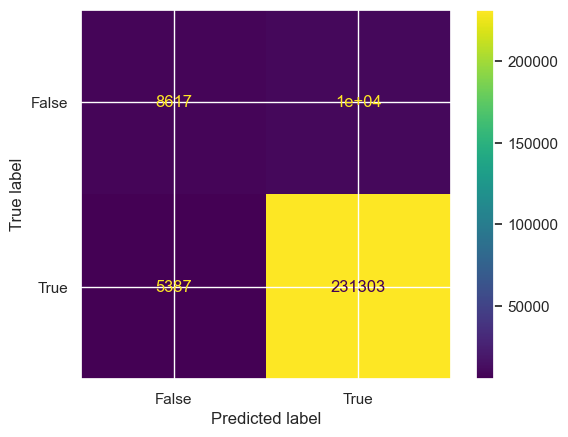

In [53]:
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

Nous avons obtenu une bonne précision avec la régression logistique.
Mais elle peut nous induire en erreur et nous devons donc vérifier les autres paramètres.
Le score F1 indique que nous avons bien prédit les patients qui ont survécu, mais nous ne pouvons pas en dire autant des patients décédés.
Il en va de même pour la matrice de confusion. Ce problème est basé sur un jeu de données déséquilibré comme je l'ai mentionné.

Or pour résoudre le problème de déséquilibre des données, il faut soit
- Charger plus de données, ou
- Modifier les mesures de performance ne pas utiliser l'accuracy,
- Rééchantillonnage (sous-échantillonnage ou suréchantillonnage)
- Modification de l'algorithme
- Modèles pénalisés, etc.

Nous choisissons de faire un rééchantillonnage et plus prcisement un sous-échantillonnage.


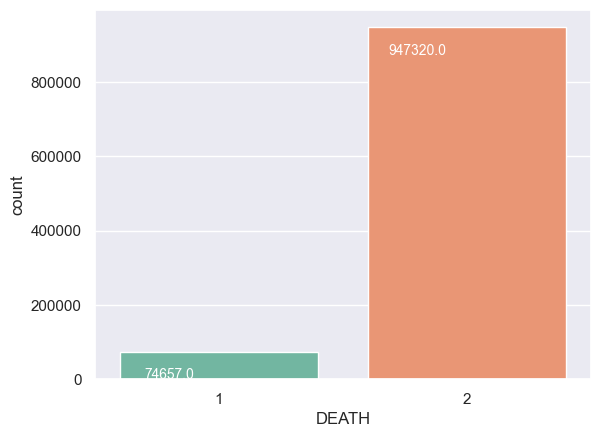

In [29]:
rgb_values = sns.color_palette("Set2", 6)
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=df['DEATH'], data=df, palette=rgb_values)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)
plt.show()

Je vais utiliser le sous-échantillonnage pour ce cas car nous avons déjà trop de patients.
Sous-échantillonnage : le sous-échantillonnage est une technique permettant d'équilibrer des ensembles de données inégaux en conservant toutes les données dans la classe minoritaire et en diminuant la taille de la classe majoritaire.
Si nous utilisons le suréchantillonnage, le nombre de lignes augmentera, ce qui signifie qu'il y a trop de lignes pour l'ordinateur.

In [13]:
#Reechantillonnage
def Reechantillonnage(x,y):
    rus = RandomUnderSampler(random_state=0)
    x_resampled,y_resampled = rus.fit_resample(x,y)
    return x_resampled,y_resampled

In [14]:
def preprocessing2(df):
    df = encodage(df)
    df = normalisation(df)
    X = df.drop('DEATH', axis=1)
    y = df['DEATH']
    print(y.value_counts())
    x_res,y_res=Reechantillonnage(X,y)
    print(y_res.value_counts())
    return x_res,y_res

In [15]:
X_train, y_train = preprocessing2(trainset)

2    710630
1     55852
Name: DEATH, dtype: int64
1    55852
2    55852
Name: DEATH, dtype: int64


In [16]:
X_test, y_test = preprocessing2(testset)

2    236690
1     18805
Name: DEATH, dtype: int64
1    18805
2    18805
Name: DEATH, dtype: int64


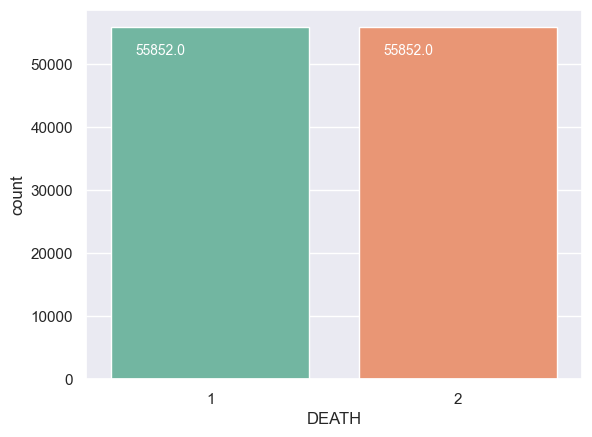

In [59]:
rgb_values = sns.color_palette("Set2", 6)
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=y_resampled,data=df, palette=rgb_values)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)
plt.show()

In [60]:
logReg_model = LogisticRegression()
# Model Training
logReg_model.fit(X_train,y_train)
# Prediction
y_pred = logReg_model.predict(X_test)

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [61]:
# Accuracy Score:
print("Accuracy Score:",accuracy_score(y_test,y_pred))

# Precision:
print("Precision Score:", precision_score(y_test,y_pred))

# Recall:
print("Recall Score:" ,recall_score(y_test,y_pred))

# F1 Score:
print("F1 Score:", f1_score(y_test,y_pred))

Accuracy Score: 0.9089603828768944
Precision Score: 0.897257089725709
Recall Score: 0.9236905078436586
F1 Score: 0.910281941096321


In [62]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[17370,  1435],
       [ 1989, 16816]], dtype=int64)

In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.90      0.92      0.91     18805
           2       0.92      0.89      0.91     18805

    accuracy                           0.91     37610
   macro avg       0.91      0.91      0.91     37610
weighted avg       0.91      0.91      0.91     37610



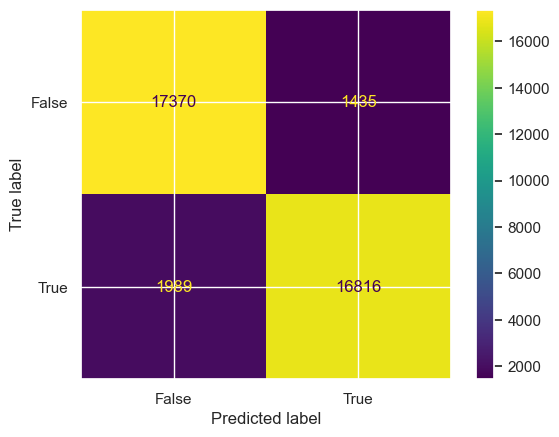

In [64]:
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

In [72]:
X_tot,y_tot=preprocessing2(df)

2    947320
1     74657
Name: DEATH, dtype: int64
1    74657
2    74657
Name: DEATH, dtype: int64


In [73]:
#validation croisee pour comparaison finale
validation_croisee = KFold(10) # Pour avoir les données pour une validation croisée avec 10 tas
#Evaluation des scores à chaque itération
scores_logReg= cross_val_score(LogisticRegression(), X_tot,y_tot, cv = validation_croisee)

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

### KNN

In [74]:
n_neighbors=30
scores=[]
for k in range(1,30):
    knn=KNeighborsClassifier(n_neighbors-k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    #print('Accuracy for k=',k,'is:',round(accuracy_score(y_pred,y_test),2))
    scores.append(round(accuracy_score(y_pred,y_test),2))

Text(0, 0.5, 'Testing Accuracy')

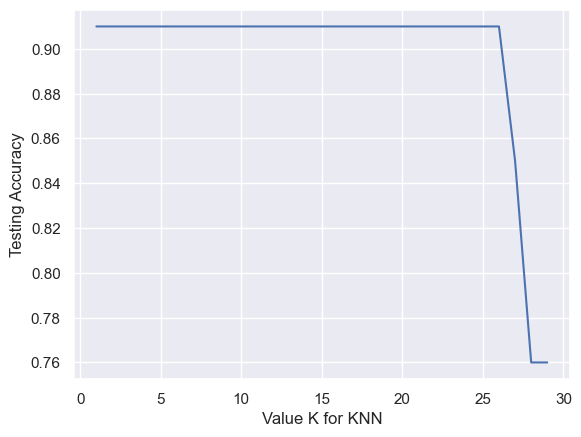

In [75]:
plt.plot(range(1,30),scores)
plt.xlabel('Value K for KNN')
plt.ylabel('Testing Accuracy')

In [76]:
#validation croisee pour comparaison finale
validation_croisee = KFold(10) # Pour avoir les données pour une validation croisée avec 10 tas
#Evaluation des scores à chaque itération
scores_KNN= cross_val_score(KNeighborsClassifier(n_neighbors=5), X_tot,y_tot, cv = validation_croisee)

### Decision tree

In [17]:
tree_model = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=5)
tree_model.fit(X_train, y_train)   #Fit the classifier with default hyper-parameters
y_pred=tree_model.predict(X_test)   # evaluating our model

In [18]:
# Accuracy Score:
print("Accuracy Score:",accuracy_score(y_test,y_pred))

# Precision:
print("Precision Score:", precision_score(y_test,y_pred))

# Recall:
print("Recall Score:" ,recall_score(y_test,y_pred))

# F1 Score:
print("F1 Score:", f1_score(y_test,y_pred))

Accuracy Score: 0.9092262696091465
Precision Score: 0.8795561035758324
Recall Score: 0.9483116192501995
F1 Score: 0.9126407369498465


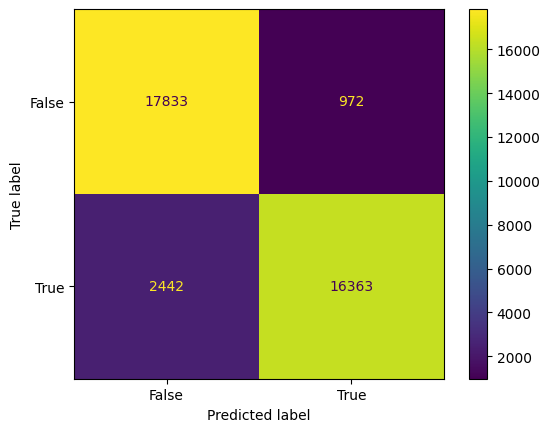

In [19]:
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

In [79]:
#validation croisee pour comparaison finale
validation_croisee = KFold(10) # Pour avoir les données pour une validation croisée avec 10 tas
#Evaluation des scores à chaque itération
scores_Tree= cross_val_score(DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=5), X_tot,y_tot, cv = validation_croisee)

### Random forest

In [81]:
RF_model=RandomForestClassifier(max_depth=5, max_features='auto', n_estimators=10,random_state=42)
RF_model.fit(X_train, y_train)  #Training our model
y_pred=RF_model.predict(X_test)  #testing our model
print("Accuracy:",accuracy_score(y_test, y_pred)) 

Accuracy: 0.9082956660462643


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

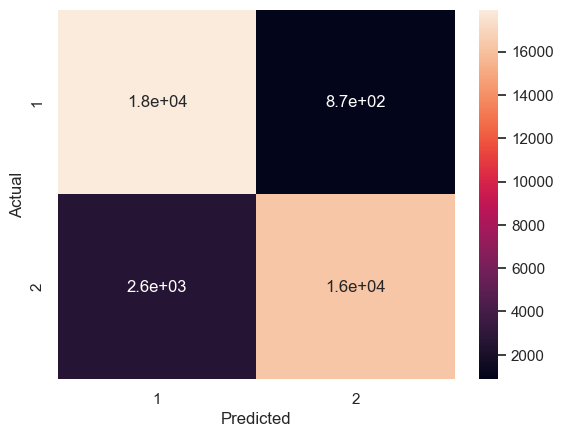

In [82]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [83]:
#validation croisee pour comparaison finale
validation_croisee = KFold(10) # Pour avoir les données pour une validation croisée avec 10 tas
#Evaluation des scores à chaque itération
scores_RF= cross_val_score(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), X_tot,y_tot, cv = validation_croisee)

#### Comparaison des modèles

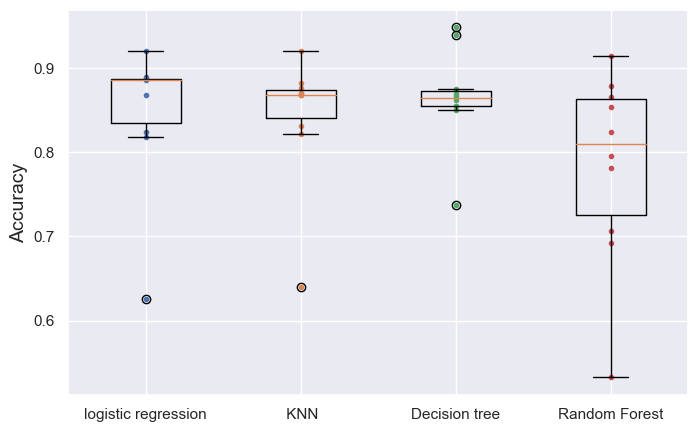

In [84]:
plt.figure(figsize=(8, 5))
plt.plot([1]*10, scores_logReg, ".")
plt.plot([2]*10, scores_KNN, ".")
plt.plot([3]*10, scores_Tree, ".")
plt.plot([4]*10, scores_RF, ".")
plt.boxplot([scores_logReg, scores_KNN, scores_Tree, scores_RF ], labels=("logistic regression"," KNN","Decision tree","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Nous allons choisir decision tree car il a glabalement les meilleurs scores avec moin de variance.

In [20]:
import joblib
joblib.dump(tree_model,"final_model_covid.joblib")

['final_model_covid.joblib']